In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pd_abundance = pd.read_csv('../input/human-gut-microbiome-with-asd/GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv')
pd_meta_abundance = pd.read_csv('../input/human-gut-microbiome-with-asd/ASD meta abundance.csv')

In [ ]:
taxa = pd_abundance[['OTU', 'taxonomy']].set_index('OTU')
taxa.head()

In [ ]:
taxa.to_csv('taxa1.csv', index_col=0)

In [ ]:
pd_abundance_T = pd_abundance.drop('taxonomy', axis=1).set_index('OTU').transpose()
pd_abundance_T.head()

In [ ]:
target = pd_abundance_T.index.to_list()
target

In [ ]:

binary_target = np.array([0 if t.startswith('A') else 1 for t in target ])

total_species = pd_abundance_T.sum(axis = 1)
abs_abundance = 31757
pd_rel_abundance = pd_abundance_T / abs_abundance 


In [ ]:
disease_df = pd_rel_abundance.copy()
disease_df['label'] = binary_target
disease_df

In [ ]:
disease_df.to_csv('df.csv', index_col=0)

## Transformer-based Modeling

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap

# Set random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----------------------------
# Custom Dataset
# ----------------------------
class MicrobiomeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----------------------------
# Transformer Model Definition
# ----------------------------
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))  # (batch, seq_len=1, d_model)
        x = self.transformer_encoder(x)     # (batch, seq_len=1, d_model)
        x = x.squeeze(1)                    # remove seq_len dimension
        out = self.classifier(x)
        return out.squeeze()

# ----------------------------
# Training & Evaluation Logic
# ----------------------------
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch)
            preds.extend(output.numpy())
            labels.extend(y_batch.numpy())
    preds = np.array(preds)
    labels = np.array(labels)
    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, preds > 0.5)
    recall = recall_score(labels, preds > 0.5)
    precision = precision_score(labels, preds > 0.5)
    cm = confusion_matrix(labels, preds > 0.5)
    return auc, f1, recall, precision, cm

# ----------------------------
# SHAP Interpretability
# ----------------------------
def explain_with_shap(model, X_val_df):
    model.eval()
    background_np = X_val_df.sample(n=min(50, len(X_val_df)), random_state=SEED).values
    test_np = X_val_df.values

    def wrapped_model(x_np):
        x_tensor = torch.tensor(x_np, dtype=torch.float32)
        with torch.no_grad():
            return model(x_tensor).detach().cpu().numpy()

    explainer = shap.Explainer(wrapped_model, background_np, algorithm="permutation")
    shap_values = explainer(test_np, max_evals=2 * test_np.shape[1] + 1)

    shap.summary_plot(shap_values, X_val_df, plot_type="bar")
    shap.summary_plot(shap_values, X_val_df)
    
    return shap_values

# ----------------------------
# Main Runner
# ----------------------------
def run_pipeline(dataframe, label_col='label', test_size=0.2):
    X = dataframe.drop(columns=[label_col])
    y = dataframe[label_col]

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=test_size, random_state=SEED, stratify=y)

    train_dataset = MicrobiomeDataset(X_train, y_train)
    val_dataset = MicrobiomeDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = TransformerClassifier(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()

    for epoch in range(1, 21):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        auc, f1, recall, precision, cm = evaluate_model(model, val_loader)
        print(f"Epoch {epoch:2d} | Loss: {train_loss:.4f} | AUC: {auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f}")
        print("Confusion Matrix:\n", cm)

    shap_values = explain_with_shap(model, X_val)
    return model, X_val, y_val, shap_values

In [ ]:

# Example usage (you must load your cleaned DataFrame first with a 'Label' column):
df = pd.read_csv("/kaggle/input/asd-gse-processed-dataset/GSE_df.csv")
df.head()

In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

In [ ]:
model, X_val, y_val, shap_values = run_pipeline(df)


In [ ]:
taxa = pd.read_csv('/kaggle/input/asd-gse-processed-dataset/GSE_taxa.csv')
taxa

In [ ]:
# Load OTU → taxonomy mapping
taxa_df = pd.read_csv('/kaggle/input/asd-gse-processed-dataset/GSE_taxa.csv')

# Get top SHAP features
top_features = X_val.columns[np.argsort(-np.abs(shap_values.values).mean(0))[:20]]  # top 20

# Map top OTUs to readable names
mapped = taxa_df.set_index('OTU').loc[top_features]
for otu, taxonomy in mapped['taxonomy'].items():
    print(f"{otu}: {taxonomy}")


## GNN-based Modeling

In [ ]:
pip install -q torch_geometric

In [ ]:
# gnn_microbiome_model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.explain.algorithm import GNNExplainer as NewGNNExplainer
from torch_geometric.explain import Explainer, ModelConfig
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----------------------------
# Graph Dataset Preparation
# ----------------------------
def build_graph_dataset(X, y):
    data_list = []
    feature_names = X.columns
    edge_index = get_feature_cooccurrence_edges(X)
    for i in range(X.shape[0]):
        node_features = torch.tensor(X.iloc[i].values, dtype=torch.float32).unsqueeze(1)
        label = torch.tensor([y.iloc[i]], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        data_list.append(graph)
    return data_list

# ----------------------------
# Simple Co-occurrence-based Edge Construction
# ----------------------------
def get_feature_cooccurrence_edges(X, threshold=0.1):
    corr = X.corr().fillna(0)
    edges = []
    for i in range(len(corr)):
        for j in range(i + 1, len(corr)):
            if abs(corr.iloc[i, j]) > threshold:
                edges.append([i, j])
                edges.append([j, i])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# ----------------------------
# GCN Classifier Model
# ----------------------------
class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# ----------------------------
# Training & Evaluation Functions
# ----------------------------
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            prob = F.softmax(out, dim=1)[:, 1]
            y_true.extend(data.y.numpy())
            y_pred.extend(pred.numpy())
            y_probs.extend(prob.numpy())
    auc = roc_auc_score(y_true, y_probs)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return auc, f1, recall, precision

# ----------------------------
# GNN Explanation (Top Influential Nodes)
# ----------------------------
def explain_graph(model, data_sample):
    model.eval()
    explainer = Explainer(
        model=model,
        algorithm=NewGNNExplainer(epochs=100),
        model_config=ModelConfig(
            mode="classification",
            task_level="graph",
            return_type="logits"
        ),
        explanation_type="model"
    )
    explanation = explainer(
        x=data_sample.x,
        edge_index=data_sample.edge_index,
        target=data_sample.y
    )
    explanation.visualize_graph(edge_text=False)
    plt.title("GNN Explainer - Important Microbial Nodes")
    plt.show()

# ----------------------------
# Full Pipeline Function
# ----------------------------
def run_gnn_pipeline(df, label_col='label'):
    X = df.drop(columns=[label_col])
    y = df[label_col]
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    train_data = build_graph_dataset(X_train, y_train)
    test_data = build_graph_dataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32)

    model = GCNClassifier(in_channels=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, 3):
        loss = train(model, train_loader, optimizer, criterion)
        auc, f1, recall, precision = evaluate(model, test_loader)
        print(f"Epoch {epoch:2d} | Loss: {loss:.4f} | AUC: {auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f}")

    # # Explain one sample from test set
    # if len(test_data) > 0:
    #     explain_graph(model, test_data[0])

    return model


In [ ]:
model = run_gnn_pipeline(df)


## Taxanomy-Informed Modeling

In [10]:
# taxonomy_informed_nn.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import shap
import matplotlib.pyplot as plt
import json
import datetime

# ----------------------------
# Preprocessing Function
# ----------------------------
def preprocess_data(df, label_col='label'):
    X = df.drop(columns=[label_col])
    y = df[label_col]
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X_scaled, y

# ----------------------------
# Hierarchical Feature Grouping by Taxonomy
# ----------------------------
def split_by_taxonomic_groups(X, taxonomy_map):
    grouped_inputs = []
    for group_name, features in taxonomy_map.items():
        common_features = [f for f in features if f in X.columns]
        grouped_inputs.append(X[common_features])
    return grouped_inputs

# ----------------------------
# Taxonomy-Informed Neural Net
# ----------------------------
def build_taxonomy_model(input_shapes, dropout_rate=0.2):
    sub_models = []
    sub_inputs = []
    for shape in input_shapes:
        input_tensor = Input(shape=(shape,))
        x = Dense(32, activation='relu')(input_tensor)
        x = Dropout(dropout_rate)(x)
        sub_models.append(x)
        sub_inputs.append(input_tensor)

    merged = Concatenate()(sub_models)
    x = Dense(64, activation='relu')(merged)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=sub_inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# Save Results and Configurations
# ----------------------------
def save_experiment_results(config, metrics, filename="taxonomy_nn_results.json"):
    result_entry = {
        "timestamp": datetime.datetime.now().isoformat(),
        "config": config,
        "metrics": metrics
    }
    try:
        with open(filename, "r") as f:
            all_results = json.load(f)
    except FileNotFoundError:
        all_results = []

    all_results.append(result_entry)

    with open(filename, "w") as f:
        json.dump(all_results, f, indent=4)

# ----------------------------
# SHAP Explainability using KernelExplainer with flattened input
# ----------------------------
def explain_with_shap(model, grouped_X_test):
    # Flatten grouped input
    X_flat = pd.concat([pd.DataFrame(g[:10]) for g in grouped_X_test], axis=1)
    background_np = X_flat.values[:10]
    test_np = X_flat.values[:10]

    def wrapped_model(X):
        split_inputs = []
        idx = 0
        for g in grouped_X_test:
            width = g.shape[1]
            split_inputs.append(X[:, idx:idx+width])
            idx += width
        return model.predict(split_inputs)

    explainer = shap.KernelExplainer(wrapped_model, background_np)
    shap_values = explainer.shap_values(test_np)

    shap.summary_plot(shap_values[0], X_flat, plot_type="bar")
    shap.summary_plot(shap_values[0], X_flat)
    return shap_values

# ----------------------------
# Training Wrapper
# ----------------------------
def run_taxonomy_nn_pipeline(df, taxonomy_map, label_col='label'):
    X, y = preprocess_data(df, label_col)
    grouped_X = split_by_taxonomic_groups(X, taxonomy_map)
    input_shapes = [group.shape[1] for group in grouped_X]

    # Correct splitting logic
    train_idx, test_idx = train_test_split(
        np.arange(len(y)), stratify=y, test_size=0.2, random_state=42
    )
    X_train = [group.iloc[train_idx].values for group in grouped_X]
    X_test  = [group.iloc[test_idx].values for group in grouped_X]
    y_train = y.iloc[train_idx].values
    y_test  = y.iloc[test_idx].values

    model = build_taxonomy_model(input_shapes)
    plot_model(model, show_shapes=True, show_layer_names=True)

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        # callbacks=[early_stop],
        verbose=1
    )

    y_probs = model.predict(X_test).ravel()
    y_preds = (y_probs >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_probs)
    f1 = f1_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)

    print(f"Test AUC: {auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f}")

    # Save configuration and results
    config = {
        "input_shapes": input_shapes,
        "dropout_rate": 0.2,
        "epochs": 100,
        "batch_size": 32,
        "taxonomy_levels": list(taxonomy_map.keys())
    }
    metrics = {
        "AUC": auc,
        "F1": f1,
        "Recall": recall,
        "Precision": precision
    }
    save_experiment_results(config, metrics)

    # SHAP Explainability
    shap_values = explain_with_shap(model, X_test)

    return model, X_test, y_test, shap_values


In [11]:
taxa_df = pd.read_csv('/kaggle/input/asd-gse-processed-dataset/GSE_taxa.csv')
taxa_df.head()

,OTU,taxonomy
0,OTU1,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...
1,OTU2,d__Bacteria;_k__norank;_p__Proteobacteria;_c__...
2,OTU3,d__Bacteria;_k__norank;_p__Firmicutes;_c__Erys...
3,OTU4,d__Bacteria;_k__norank;_p__Firmicutes;_c__Baci...
4,OTU5,d__Bacteria;_k__norank;_p__Tenericutes;_c__Mol...


In [12]:
taxa_df.taxonomy[0]

'd__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Defluviitaleaceae;_g__Defluviitaleaceae_UCG-011;_s__Lachnospiraceae_bacterium_feline_oral_taxon_001'

In [13]:
df = pd.read_csv("/kaggle/input/asd-gse-processed-dataset/GSE_df.csv")


In [14]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1330,OTU1331,OTU1332,OTU1333,OTU1334,OTU1335,OTU1336,OTU1337,OTU1338,label
0,0.0,0.0,0.0,0.0,0.000000,0.000031,0.000000,0.000000,0.001574,0.000000,...,0.000000,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000315,0.000063,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.000031,0.000000,0.000000,0.015272,0.000409,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000031,0.004471,0.000535,0.000000,...,0.000031,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000031,0.000283,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
import pandas as pd
from collections import defaultdict

def generate_taxonomy_map(taxa_csv_path, level='_p__'):
    df = pd.read_csv(taxa_csv_path)
    taxonomy_map = defaultdict(list)

    for _, row in df.iterrows():
        otu = row['OTU']
        tax_path = row['taxonomy']
        parts = tax_path.split(';')
        group = [t for t in parts if t.startswith(level)]
        if group:
            taxonomy_map[group[0]].append(otu)
    return dict(taxonomy_map)


In [16]:
taxonomy_map = generate_taxonomy_map('/kaggle/input/asd-gse-processed-dataset/GSE_taxa.csv')

In [8]:
taxonomy_map

{'_p__Firmicutes': ['OTU1',
  'OTU3',
  'OTU4',
  'OTU6',
  'OTU7',
  'OTU9',
  'OTU12',
  'OTU17',
  'OTU19',
  'OTU20',
  'OTU22',
  'OTU24',
  'OTU25',
  'OTU27',
  'OTU30',
  'OTU31',
  'OTU37',
  'OTU38',
  'OTU39',
  'OTU41',
  'OTU42',
  'OTU44',
  'OTU46',
  'OTU48',
  'OTU50',
  'OTU51',
  'OTU54',
  'OTU55',
  'OTU57',
  'OTU59',
  'OTU60',
  'OTU61',
  'OTU62',
  'OTU68',
  'OTU70',
  'OTU71',
  'OTU72',
  'OTU73',
  'OTU74',
  'OTU75',
  'OTU76',
  'OTU77',
  'OTU78',
  'OTU85',
  'OTU86',
  'OTU89',
  'OTU91',
  'OTU93',
  'OTU94',
  'OTU97',
  'OTU99',
  'OTU100',
  'OTU103',
  'OTU105',
  'OTU106',
  'OTU109',
  'OTU110',
  'OTU112',
  'OTU113',
  'OTU114',
  'OTU116',
  'OTU117',
  'OTU118',
  'OTU119',
  'OTU120',
  'OTU124',
  'OTU126',
  'OTU127',
  'OTU128',
  'OTU130',
  'OTU131',
  'OTU132',
  'OTU133',
  'OTU134',
  'OTU135',
  'OTU136',
  'OTU138',
  'OTU140',
  'OTU141',
  'OTU142',
  'OTU143',
  'OTU145',
  'OTU147',
  'OTU148',
  'OTU149',
  'OTU150',
  'OTU1

In [9]:
# def preprocess_data(df, label_col='label'):
#     X = df.drop(columns=[label_col])
#     y = df[label_col]
#     scaler = StandardScaler()
#     X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#     return X_scaled, y

# X, y = preprocess_data(df)
# X.shape, y.shape

SyntaxError: incomplete input (971748716.py, line 9)

In [11]:
# X

,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1329,OTU1330,OTU1331,OTU1332,OTU1333,OTU1334,OTU1335,OTU1336,OTU1337,OTU1338
0,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,4.490731,-0.530048,-0.180967,2.834015,-0.219116,...,1.091079,-0.392871,2.733427,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
1,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,-0.222681,-0.530048,-0.180967,-0.443198,6.737830,...,6.689746,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
2,-0.062869,-0.062869,-0.238738,-0.327772,0.141054,-0.222681,-0.530048,0.774598,-0.197407,-0.219116,...,-0.308588,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
3,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,-0.222681,0.178543,0.098807,0.130314,-0.219116,...,-0.308588,1.270282,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
4,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,-0.222681,-0.530048,-0.178997,-0.525128,-0.219116,...,1.091079,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,4.490731,0.178543,-0.180967,-1.262501,-0.219116,...,-0.308588,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
250,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,-0.222681,-0.530048,-0.131711,-1.098640,-0.219116,...,1.091079,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
251,-0.062869,-0.062869,-0.238738,-0.327772,-0.285466,-0.222681,-0.530048,-0.141562,-0.688989,-0.219116,...,1.091079,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987
252,-0.062869,-0.062869,-0.238738,2.357842,-0.285466,-0.222681,0.178543,-0.180967,-0.197407,-0.219116,...,-0.308588,-0.392871,-0.338655,-0.200327,-0.103005,-0.199273,-0.062869,-0.119421,-0.134298,-0.134987


In [12]:
# y

0      0
1      0
2      0
3      0
4      0
      ..
249    1
250    1
251    1
252    1
253    1
Name: label, Length: 254, dtype: int64

In [14]:
# len(X.columns)

1322

In [18]:
# for group_name, features in taxonomy_map.items():
#     common_features = [f for f in features if f in X.columns]
#     if len(common_features) == 3:
#         print(len(common_features))
#         print(common_features)
    

3
['OTU737', 'OTU748', 'OTU1103']


In [19]:
# X[['OTU737', 'OTU748', 'OTU1103']]

,OTU737,OTU748,OTU1103
0,-0.062869,-0.254844,-0.212110
1,-0.062869,3.186651,-0.212110
2,-0.062869,-0.103014,-0.212110
3,-0.062869,0.200648,-0.212110
4,-0.062869,-0.305455,-0.212110
...,...,...,...
249,-0.062869,0.807970,-0.212110
250,-0.062869,-0.153624,-0.212110
251,-0.062869,-0.305455,0.361039
252,-0.062869,-0.153624,-0.212110


In [ ]:
# grouped_inputs = []
# for group_name, features in taxonomy_map.items():
#     common_features = [f for f in features if f in X.columns]
#     grouped_inputs.append(X[common_features])


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5743 - loss: 0.7173 - val_accuracy: 0.6341 - val_loss: 0.6327
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7026 - loss: 0.5699 - val_accuracy: 0.7073 - val_loss: 0.5863
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8534 - loss: 0.4401 - val_accuracy: 0.6585 - val_loss: 0.5919
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8617 - loss: 0.3768 - val_accuracy: 0.6585 - val_loss: 0.6054
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9224 - loss: 0.2920 - val_accuracy: 0.6829 - val_loss: 0.6181
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9209 - loss: 0.2399 - val_accuracy: 0.6829 - val_loss: 0.6409
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9861 - loss: 0.1256 - val_accuracy: 0.6829 - val_loss: 0.6733
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9723 - loss: 0.1278 - val_accuracy: 0.6585 - val_loss: 

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


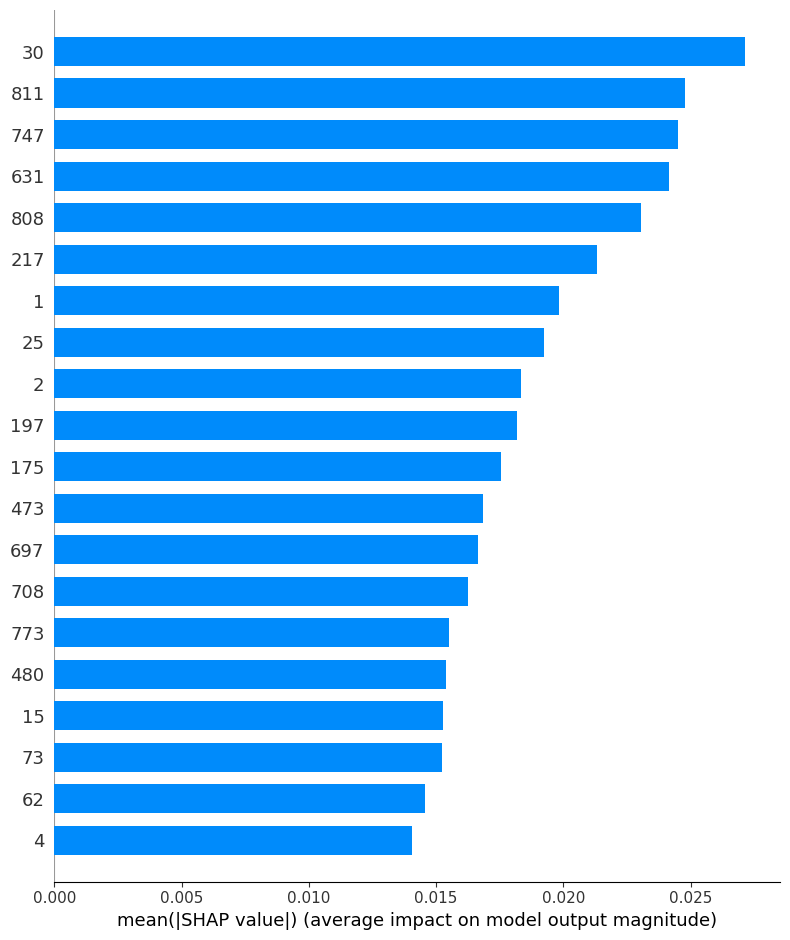

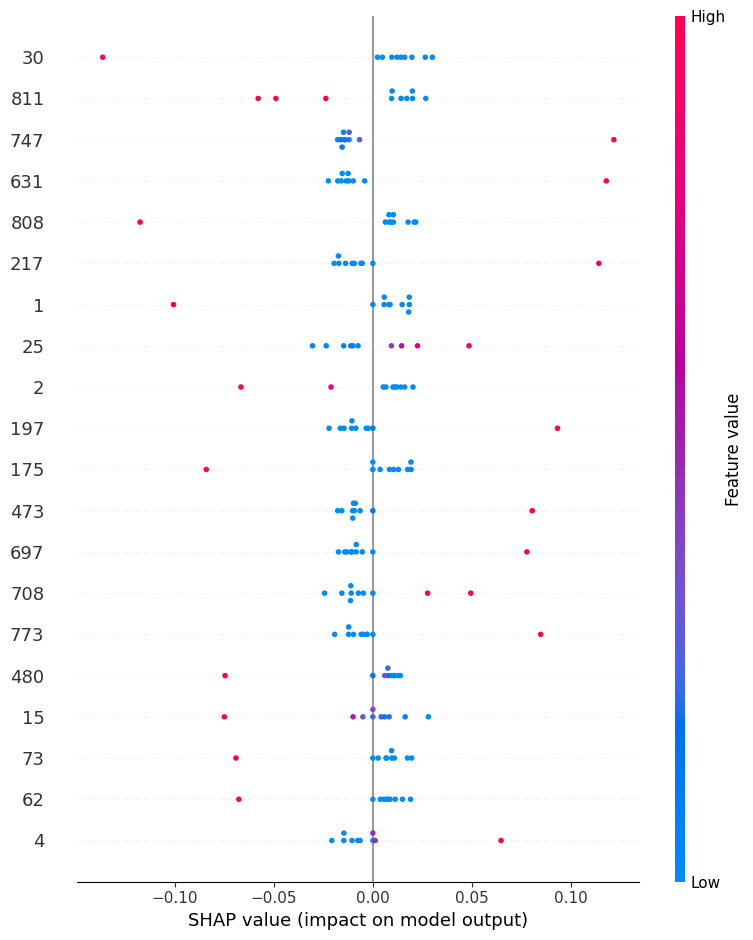

In [17]:
model, X_test, y_test, shap_values = run_taxonomy_nn_pipeline(df, taxonomy_map, label_col='label')

# Capsule Networks

2025-08-03 19:55:56.793094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754250956.978002      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754250957.034796      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TaxoCaps for GSE Microbiome Analysis
=== Starting TaxoCaps Pipeline for GSE Dataset ===

1. Loading GSE dataset...
Loaded dataset with shape: (254, 1324)

2. Loading and parsing taxonomy mapping...
Taxonomy file info:
Shape: (1322, 2)
Columns: ['OTU', 'taxonomy']
First few rows:
    OTU                                           taxonomy
0  OTU1  d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...
1  OTU2  d__Bacteria;_k__norank;_p__Proteobacteria;_c__...
2  OTU3  d__Bacteria;_k__norank;_p__Firmicutes;_c__Erys...
3  OTU4  d__Bacteria;_k__norank;_p__Firmicutes;_c__Baci...
4  OTU5  d__Bacteria;_k__norank;_p__Tenericutes;_c__Mol...
Using OTU column: OTU
Using taxonomy column: taxonomy

Created taxonomy map with 12 phyla:
  Firmicutes: 815 OTUs
  Proteobacteria: 117 OTUs
  Tenericutes: 31 OTUs
  Bacteroidetes: 251 OTUs
  Actinobacteria: 65 OTUs
  Deinococcus-Thermus: 4 OTUs
  Lentisphaerae: 6 OTUs
  unclassified_k__norank: 4 OTUs
  Fusobacteria: 6 OTUs
  Saccharibacteria: 5 OTUs
  Synergistet

I0000 00:00:1754250970.188684      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model architecture:
  Number of phylum inputs: 13
  Firmicutes: 812 OTU features
  Proteobacteria: 116 OTU features
  Tenericutes: 31 OTU features
  Bacteroidetes: 250 OTU features
  Actinobacteria: 64 OTU features
  Deinococcus-Thermus: 4 OTU features
  Lentisphaerae: 6 OTU features
  unclassified_k__norank: 3 OTU features
  Fusobacteria: 6 OTU features
  Saccharibacteria: 5 OTU features
  Synergistetes: 3 OTU features
  Cyanobacteria: 6 OTU features
  Unknown_Phylum: 9 OTU features

6. Model Summary:


Model: "TaxoCaps"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_Firmicutes          │ (None, 812)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Proteobacteria      │ (None, 116)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Tenericutes         │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Bacteroidetes       │ (None, 250)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Actinobacteria      │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Deinococcus_Thermus │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Lentisphaerae       │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_unclassified_k_nor… │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Fusobacteria        │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Saccharibacteria    │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Synergistetes       │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Cyanobacteria       │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_Unknown_Phylum      │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 300,064 (1.14 MB)

 Trainable params: 300,064 (1.14 MB)

 Non-trainable params: 0 (0.00 B)


7. Training model...
Epoch 1/100


I0000 00:00:1754251001.776111      99 service.cc:148] XLA service 0x7b2e10029b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754251001.776756      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754251004.879246      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/7 ━━━━━━━━━━━━━━━━━━━━ 4:21 44s/step - accuracy: 0.5938 - loss: 0.6931

I0000 00:00:1754251016.177132      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.5164 - loss: 0.6931 - val_accuracy: 0.7255 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6536 - loss: 0.6927 - val_accuracy: 0.6863 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7086 - loss: 0.6873 - val_accuracy: 0.8431 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8369 - loss: 0.6595 - val_accuracy: 0.9020 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9286 - loss: 0.5752 - val_accuracy: 0.9216 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9560 - loss: 0.4751 - val_accuracy: 0.9412 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9882 - loss: 0.4047 - val_accuracy: 0.9216 - val_

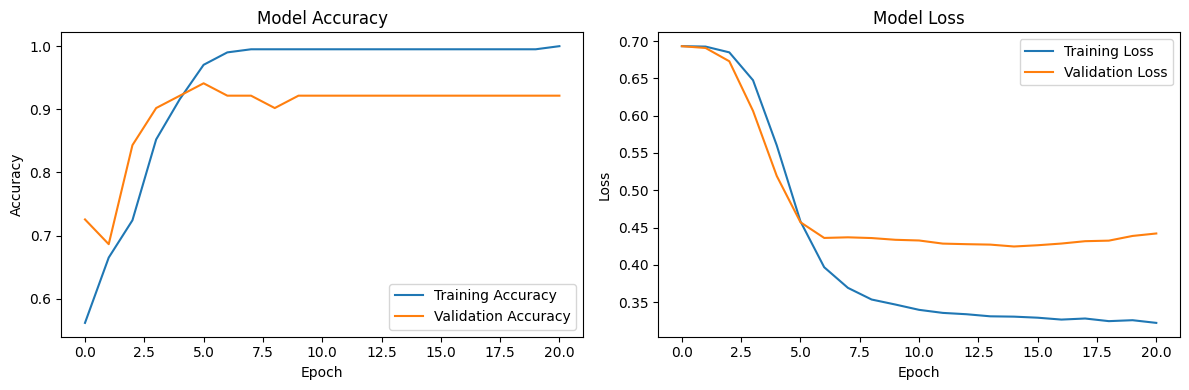


9. Evaluating model performance...
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Model Evaluation Results:
Accuracy: 0.9412
ROC AUC: 0.9859

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        29
           1       0.88      1.00      0.94        22

    accuracy                           0.94        51
   macro avg       0.94      0.95      0.94        51
weighted avg       0.95      0.94      0.94        51


=== GSE Pipeline completed successfully! ===
Final model accuracy: 0.9412

=== Analysis Summary ===
✓ Successfully trained TaxoCaps model
✓ Model accuracy: 0.9412
✓ ROC AUC: 0.9859
✓ Number of phyla analyzed: 13
🎉 Analysis complete!!


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer
import keras

@register_keras_serializable()
class CapsuleLayer(layers.Layer):
    """Custom Capsule Layer with Dynamic Routing"""
    
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings
        
    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transformation matrix W
        self.W = self.add_weight(
            name='W',
            shape=[self.input_num_capsules, self.num_capsules, 
                   self.input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            trainable=True
        )
        
        super(CapsuleLayer, self).build(input_shape)
        
    def call(self, inputs, training=None):
        # inputs shape: [batch_size, input_num_capsules, input_dim_capsule]
        batch_size = tf.shape(inputs)[0]
        
        # Expand inputs for matrix multiplication
        inputs_expand = tf.expand_dims(inputs, 2)  # [batch, in_caps, 1, in_dim]
        inputs_expand = tf.expand_dims(inputs_expand, 4)  # [batch, in_caps, 1, in_dim, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1, 1])
        
        # Compute prediction vectors u_hat
        W_tiled = tf.tile(tf.expand_dims(self.W, 0), [batch_size, 1, 1, 1, 1])
        u_hat = tf.matmul(W_tiled, inputs_tiled)  # [batch, in_caps, num_caps, dim_caps, 1]
        u_hat = tf.squeeze(u_hat, axis=[4])  # [batch, in_caps, num_caps, dim_caps]
        
        # Initialize routing logits
        b_ij = tf.zeros([batch_size, self.input_num_capsules, self.num_capsules])
        
        # Dynamic routing algorithm
        for i in range(self.routings):
            # Calculate coupling coefficients
            c_ij = tf.nn.softmax(b_ij, axis=2)  # [batch, in_caps, num_caps]
            c_ij_expanded = tf.expand_dims(c_ij, -1)  # [batch, in_caps, num_caps, 1]
            
            # Calculate weighted sum s_j
            s_j = tf.reduce_sum(c_ij_expanded * u_hat, axis=1)  # [batch, num_caps, dim_caps]
            
            # Apply squash function
            v_j = self.squash(s_j)
            
            # Update routing logits (except for last iteration)
            if i < self.routings - 1:
                v_j_expanded = tf.expand_dims(v_j, 1)  # [batch, 1, num_caps, dim_caps]
                agreement = tf.reduce_sum(u_hat * v_j_expanded, axis=-1)  # [batch, in_caps, num_caps]
                b_ij += agreement
                
        return v_j
    
    def squash(self, vectors):
        """Squashing function to ensure capsule output magnitude is [0,1]"""
        vec_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
        scalar_factor = vec_squared_norm / (1 + vec_squared_norm) / tf.sqrt(vec_squared_norm + 1e-7)
        return scalar_factor * vectors
    
    def get_config(self):
        config = super().get_config()  # ✅ this works with modern Python
        config.update({
            'num_capsules': self.num_capsules,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        })
        return config


def parse_taxonomy_string(taxonomy_str: str) -> Dict[str, str]:
    """Parse semicolon-separated taxonomy string into taxonomic levels"""
    taxonomy_dict = {}
    
    if pd.isna(taxonomy_str) or taxonomy_str == '':
        return taxonomy_dict
    
    # Split by semicolon and process each level
    levels = taxonomy_str.split(';')
    
    for level in levels:
        level = level.strip()
        if '__' in level:
            # Extract taxonomic rank and name
            rank_name = level.split('__', 1)
            if len(rank_name) == 2:
                rank, name = rank_name
                rank = rank.strip('_')
                if name and name != 'norank' and name != '':
                    taxonomy_dict[rank] = name
    
    return taxonomy_dict

def generate_taxonomy_map(taxa_file: str = None) -> Dict[str, List[str]]:
    """Generate taxonomy mapping from phylum to OTUs for GSE dataset"""
    if taxa_file is None:
        # Mock taxonomy for demonstration
        taxonomy_map = {
            'p__Firmicutes': [f'Firmicutes_OTU_{i}' for i in range(50)],
            'p__Bacteroidetes': [f'Bacteroidetes_OTU_{i}' for i in range(40)],
            'p__Proteobacteria': [f'Proteobacteria_OTU_{i}' for i in range(35)],
            'p__Actinobacteria': [f'Actinobacteria_OTU_{i}' for i in range(25)],
            'p__Verrucomicrobia': [f'Verrucomicrobia_OTU_{i}' for i in range(15)]
        }
    else:
        # Load GSE taxonomy file
        df_taxa = pd.read_csv(taxa_file)
        taxonomy_map = {}
        
        print("Taxonomy file info:")
        print(f"Shape: {df_taxa.shape}")
        print(f"Columns: {df_taxa.columns.tolist()}")
        print("First few rows:")
        print(df_taxa.head())
        
        # Assuming columns are 'OTU' and 'taxonomy' based on your description
        otu_col = df_taxa.columns[0]  # Should be 'OTU'
        taxonomy_col = df_taxa.columns[1]  # Should be 'taxonomy'
        
        print(f"Using OTU column: {otu_col}")
        print(f"Using taxonomy column: {taxonomy_col}")
        
        # Parse taxonomy for each OTU
        otu_to_phylum = {}
        
        for idx, row in df_taxa.iterrows():
            otu_id = row[otu_col]
            taxonomy_str = row[taxonomy_col]
            
            # Parse taxonomy string
            taxonomy_dict = parse_taxonomy_string(taxonomy_str)
            
            # Extract phylum
            phylum = taxonomy_dict.get('p', 'Unknown_Phylum')
            
            # Store mapping
            otu_to_phylum[otu_id] = phylum
        
        # Group OTUs by phylum
        phylum_to_otus = {}
        for otu, phylum in otu_to_phylum.items():
            if phylum not in phylum_to_otus:
                phylum_to_otus[phylum] = []
            phylum_to_otus[phylum].append(otu)
        
        # Filter out phyla with too few OTUs
        min_otus_per_phylum = 3
        taxonomy_map = {
            phylum: otus for phylum, otus in phylum_to_otus.items() 
            if len(otus) >= min_otus_per_phylum
        }
        
        print(f"\nCreated taxonomy map with {len(taxonomy_map)} phyla:")
        total_otus = 0
        for phylum, otus in taxonomy_map.items():
            print(f"  {phylum}: {len(otus)} OTUs")
            total_otus += len(otus)
        
        print(f"Total OTUs mapped: {total_otus}")
        
        # Show some examples of unmapped OTUs
        unmapped_otus = [otu for otu, phylum in otu_to_phylum.items() 
                        if phylum not in taxonomy_map or len(phylum_to_otus[phylum]) < min_otus_per_phylum]
        if unmapped_otus:
            print(f"Unmapped OTUs (phyla with <{min_otus_per_phylum} OTUs): {len(unmapped_otus)}")
            if len(unmapped_otus) <= 10:
                print(f"Examples: {unmapped_otus}")
            else:
                print(f"Examples: {unmapped_otus[:10]} ...")
    
    return taxonomy_map

def preprocess_gse_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray, List[str]]:
    """Preprocess GSE microbiome data specifically"""
    
    print(f"GSE Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}..." if len(df.columns) > 10 else f"Columns: {df.columns.tolist()}")
    
    # Remove the unnamed index column if present
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
        print("Removed 'Unnamed: 0' column")
    
    # Identify OTU columns and label column
    otu_columns = [col for col in df.columns if col.startswith('OTU')]
    label_col = 'label'  # Based on your data description
    
    if label_col not in df.columns:
        print(f"Warning: '{label_col}' column not found. Available columns: {df.columns.tolist()}")
        # Try to find label column
        possible_labels = ['class', 'group', 'condition', 'disease', 'phenotype', 'target', 'y']
        for col in df.columns:
            if col.lower() in possible_labels or any(keyword in col.lower() for keyword in possible_labels):
                label_col = col
                break
        
        if label_col not in df.columns:
            raise ValueError("Could not find label column. Please specify the correct label column name.")
    
    print(f"Found {len(otu_columns)} OTU columns")
    print(f"Using label column: {label_col}")
    
    # Separate features and labels
    X = df[otu_columns].copy()
    y = df[label_col].values
    
    print(f"Label distribution: {np.bincount(y)}")
    print(f"Feature matrix shape: {X.shape}")
    
    # Check for missing values
    missing_count = X.isnull().sum().sum()
    if missing_count > 0:
        print(f"Found {missing_count} missing values, filling with 0")
        X = X.fillna(0)
    
    # Check data characteristics
    print(f"Data range: {X.min().min():.6f} to {X.max().max():.6f}")
    print(f"Mean abundance: {X.mean().mean():.6f}")
    
    # Remove OTUs with zero variance
    zero_var_otus = X.columns[X.var() == 0]
    if len(zero_var_otus) > 0:
        X = X.drop(columns=zero_var_otus)
        otu_columns = [col for col in otu_columns if col not in zero_var_otus]
        print(f"Removed {len(zero_var_otus)} zero-variance OTUs")
    
    # Remove very low abundance OTUs (present in <5% of samples)
    prevalence_threshold = 0.05
    low_prevalence_otus = X.columns[(X > 0).mean() < prevalence_threshold]
    if len(low_prevalence_otus) > 0:
        print(f"Found {len(low_prevalence_otus)} low-prevalence OTUs (present in <{prevalence_threshold*100}% of samples)")
        # Keep them for now, but note them
    
    # Apply centered log-ratio (CLR) transformation for microbiome data
    # Add pseudocount to handle zeros
    pseudocount = X[X > 0].min().min() / 2 if (X > 0).sum().sum() > 0 else 1e-6
    X_pseudo = X + pseudocount
    
    # CLR transformation: log(x/geometric_mean)
    geometric_means = np.exp(np.log(X_pseudo).mean(axis=1))
    X_clr = np.log(X_pseudo.div(geometric_means, axis=0))
    
    print("Applied CLR transformation for microbiome data")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clr)
    X_final = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    print(f"Final processed data shape: {X_final.shape}")
    print(f"Final data range: {X_final.min().min():.3f} to {X_final.max().max():.3f}")
    
    return X_final, y, otu_columns

# FIXED FUNCTION - This is the key fix for your error
def build_primary_capsules(input_layer, num_capsules: int = 8, dim_capsule: int = 16, layer_suffix: str = ""):
    """Convert OTUs to initial capsules per taxonomic group with unique layer names"""
    # Use unique layer names by adding suffix
    x = layers.Dense(64, activation='relu', name=f'primary_dense_{layer_suffix}')(input_layer)
    x = layers.Dense(32, activation='relu', name=f'primary_dense_2_{layer_suffix}')(x)
    x = layers.Dropout(0.3, name=f'primary_dropout_{layer_suffix}')(x)
    
    # Reshape for capsule processing
    x = layers.Dense(num_capsules * dim_capsule, activation='relu', name=f'primary_dense_final_{layer_suffix}')(x)
    primary_caps = layers.Reshape((num_capsules, dim_capsule), name=f'primary_reshape_{layer_suffix}')(x)
    
    return primary_caps

def build_taxon_capsules(primary_caps, taxon_rank: str, num_capsules: int = 4, layer_suffix: str = ""):
    """Route capsules based on taxonomic hierarchy with unique layer names"""
    if taxon_rank == 'phylum':
        return CapsuleLayer(num_capsules=num_capsules, dim_capsule=16, routings=3, 
                          name=f'phylum_capsule_{layer_suffix}')(primary_caps)
    elif taxon_rank == 'genus':
        return CapsuleLayer(num_capsules=num_capsules*2, dim_capsule=8, routings=3,
                          name=f'genus_capsule_{layer_suffix}')(primary_caps)
    else:
        return CapsuleLayer(num_capsules=num_capsules, dim_capsule=12, routings=3,
                          name=f'taxon_capsule_{layer_suffix}')(primary_caps)

# FIXED FUNCTION - Updated to use unique layer names
def build_taxocaps_model(input_shapes: List[int], taxonomy_map: Dict[str, List[str]]) -> models.Model:
    """Build complete TaxoCaps model with unique layer names"""
    # Input layers for each phylum
    input_layers = []
    phylum_names = list(taxonomy_map.keys())
    
    for i, shape in enumerate(input_shapes):
        phylum_name = phylum_names[i] if i < len(phylum_names) else f'phylum_{i}'
        # Clean phylum name for layer naming (remove special characters)
        clean_name = phylum_name.replace('__', '_').replace(' ', '_').replace('-', '_')
        input_layers.append(layers.Input(shape=(shape,), name=f'input_{clean_name}'))
    
    # Process each phylum group
    phylum_capsules = []
    for i, (inp, shape) in enumerate(zip(input_layers, input_shapes)):
        phylum_name = phylum_names[i] if i < len(phylum_names) else f'phylum_{i}'
        clean_name = phylum_name.replace('__', '_').replace(' ', '_').replace('-', '_')
        
        # Primary capsules for this phylum with unique naming
        primary = build_primary_capsules(inp, num_capsules=8, dim_capsule=16, layer_suffix=clean_name)
        
        # Taxon-specific routing with unique naming
        caps = build_taxon_capsules(primary, 'phylum', num_capsules=4, layer_suffix=clean_name)
        
        phylum_capsules.append(caps)
    
    # Merge all phylum capsules
    if len(phylum_capsules) > 1:
        merged = layers.Concatenate(axis=1, name='merge_phyla')(phylum_capsules)
    else:
        merged = phylum_capsules[0]
    
    # Final classification capsule
    class_caps = CapsuleLayer(num_capsules=2, dim_capsule=16, routings=3, name='class_capsules')(merged)
    
    # Output layer - magnitude of capsules indicates class probability
    @keras.saving.register_keras_serializable()
    def capsule_norm(x):
        return tf.norm(x, axis=-1)
    
    output = layers.Lambda(capsule_norm, name='capsule_magnitude')(class_caps)

    
    # Apply softmax for final probabilities
    output = layers.Activation('softmax', name='final_output')(output)
    
    model = models.Model(inputs=input_layers, outputs=output, name='TaxoCaps')
    
    return model

def prepare_taxonomy_data(df: pd.DataFrame, taxonomy_map: Dict[str, List[str]]) -> Tuple[List[np.ndarray], np.ndarray, List[str]]:
    """Prepare GSE data grouped by taxonomy for phylum-OTU relationships"""
    X, y, otu_columns = preprocess_gse_data(df)
    
    grouped_X = []
    used_phyla = []
    total_mapped_otus = 0
    
    print("\nGrouping OTUs by phylum:")
    for phylum, otus in taxonomy_map.items():
        # Find OTUs that exist in the data
        valid_otus = [otu for otu in otus if otu in X.columns]
        
        if len(valid_otus) == 0:
            print(f"  {phylum}: No matching OTUs found, skipping")
            continue
        
        # Use all valid OTUs for this phylum
        phylum_data = X[valid_otus].values
        grouped_X.append(phylum_data)
        used_phyla.append(phylum)
        total_mapped_otus += len(valid_otus)
        print(f"  {phylum}: {len(valid_otus)} OTUs")
    
    # Handle unmapped OTUs
    mapped_otus = []
    for otus in taxonomy_map.values():
        mapped_otus.extend(otus)
    
    unmapped_otus = [otu for otu in X.columns if otu not in mapped_otus]
    
    if len(unmapped_otus) > 0:
        print(f"\nFound {len(unmapped_otus)} unmapped OTUs")
        
        # Group unmapped OTUs into an "Unknown" category if there are enough
        if len(unmapped_otus) >= 5:
            unmapped_data = X[unmapped_otus].values
            grouped_X.append(unmapped_data)
            used_phyla.append("Unknown_Phylum")
            total_mapped_otus += len(unmapped_otus)
            print(f"  Unknown_Phylum: {len(unmapped_otus)} OTUs")
    
    if len(grouped_X) == 0:
        raise ValueError("No phyla had matching OTUs. Check your taxonomy mapping and OTU names.")
    
    print(f"\nFinal grouping summary:")
    print(f"  Total phylum groups: {len(grouped_X)}")
    print(f"  Total mapped OTUs: {total_mapped_otus}")
    print(f"  Coverage: {total_mapped_otus}/{len(X.columns)} ({100*total_mapped_otus/len(X.columns):.1f}%)")
    
    return grouped_X, y, used_phyla

def train_taxocaps(model: models.Model, X_train: List[np.ndarray], y_train: np.ndarray, 
                   X_val: List[np.ndarray] = None, y_val: np.ndarray = None) -> Any:
    """Train TaxoCaps model"""
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy' if X_val is not None else 'accuracy',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss' if X_val is not None else 'loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    callback_list = [early_stopping, reduce_lr]
    
    # Training
    if X_val is not None and y_val is not None:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=32,
            epochs=100,
            callbacks=callback_list,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size=32,
            epochs=100,
            callbacks=callback_list,
            verbose=1
        )
    
    return history

def evaluate_model(model: models.Model, X_test: List[np.ndarray], y_test: np.ndarray) -> Dict[str, Any]:
    """Evaluate model performance"""
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Metrics
    results = {
        'accuracy': np.mean(y_pred == y_test),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # ROC AUC if binary classification
    if len(np.unique(y_test)) == 2:
        results['roc_auc'] = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    # Print results
    print("Model Evaluation Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    if 'roc_auc' in results:
        print(f"ROC AUC: {results['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])
    
    return results

def plot_training_history(history: Any):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# FIXED PIPELINE FUNCTION
def run_gse_pipeline(df_path: str, taxonomy_path: str):
    """Run the complete TaxoCaps pipeline with GSE dataset - FIXED VERSION"""
    
    print("=== Starting TaxoCaps Pipeline for GSE Dataset ===")
    
    # 1. Load real data
    print("\n1. Loading GSE dataset...")
    df = pd.read_csv(df_path)
    print(f"Loaded dataset with shape: {df.shape}")
    
    # 2. Load taxonomy mapping
    print("\n2. Loading and parsing taxonomy mapping...")
    taxonomy_map = generate_taxonomy_map(taxonomy_path)
    
    if len(taxonomy_map) == 0:
        raise ValueError("No valid taxonomy mapping found. Check your taxonomy file.")
    
    # 3. Prepare data with phylum-OTU relationships
    print("\n3. Preparing phylum-OTU grouped data...")
    X, y, used_phyla = prepare_taxonomy_data(df, taxonomy_map)
    
    # Update taxonomy map to only include used phyla
    filtered_taxonomy_map = {phylum: taxonomy_map.get(phylum, []) for phylum in used_phyla}
    
    # Split data
    X_train_list, X_test_list = [], []
    
    print(f"\n4. Splitting data (80% train, 20% test)...")
    # Split each phylum group
    for i, phylum_data in enumerate(X):
        X_train_phylum, X_test_phylum, y_train, y_test = train_test_split(
            phylum_data, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train_list.append(X_train_phylum)
        X_test_list.append(X_test_phylum)
    
    print(f"Training samples: {len(y_train)}")
    print(f"Test samples: {len(y_test)}")
    print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")
    
    # 5. Build model with FIXED function
    print(f"\n5. Building TaxoCaps model for phylum-OTU relationships...")
    input_shapes = [x.shape[1] for x in X_train_list]
    
    # This should now work without duplicate layer names
    model = build_taxocaps_model(input_shapes, filtered_taxonomy_map)
    
    print(f"Model architecture:")
    print(f"  Number of phylum inputs: {len(input_shapes)}")
    for i, (phylum, shape) in enumerate(zip(used_phyla, input_shapes)):
        print(f"  {phylum}: {shape} OTU features")
    
    # Display model summary
    print(f"\n6. Model Summary:")
    model.summary()
    
    # 7. Train model
    print(f"\n7. Training model...")
    history = train_taxocaps(model, X_train_list, y_train, X_test_list, y_test)
    
    # 8. Plot training history
    print(f"\n8. Visualizing training progress...")
    plot_training_history(history)
    
    # 9. Evaluate model
    print(f"\n9. Evaluating model performance...")
    results = evaluate_model(model, X_test_list, y_test)
    
    print(f"\n=== GSE Pipeline completed successfully! ===")
    print(f"Final model accuracy: {results['accuracy']:.4f}")

    test_data = [X_test_list, y_test, used_phyla]
    
    return model, history, results, filtered_taxonomy_map, test_data

def analyze_gse_data():
    """Simple function to analyze your GSE data - FIXED VERSION"""
    
    # Your file paths
    df_path = '/kaggle/input/asd-gse-processed-dataset/GSE_df.csv'
    taxonomy_path = '/kaggle/input/asd-gse-processed-dataset/GSE_taxa.csv'
    
    try:
        # Run the complete pipeline with fixes
        model, history, results, taxonomy_map, test_data = run_gse_pipeline(
            df_path=df_path,
            taxonomy_path=taxonomy_path
        )
        
        print("\n=== Analysis Summary ===")
        print(f"✓ Successfully trained TaxoCaps model")
        print(f"✓ Model accuracy: {results['accuracy']:.4f}")
        if 'roc_auc' in results:
            print(f"✓ ROC AUC: {results['roc_auc']:.4f}")
        print(f"✓ Number of phyla analyzed: {len(taxonomy_map)}")
        
        return model, history, results, taxonomy_map, test_data
        
    except Exception as e:
        print(f"❌ Analysis failed: {e}")
        print("\nTroubleshooting tips:")
        print("1. Check if file paths are correct")
        print("2. Verify data format matches expected structure")  
        print("3. Ensure sufficient memory is available")
        raise

# Run the fixed analysis
if __name__ == "__main__":
    print("TaxoCaps for GSE Microbiome Analysis")
    print("===================================================")
    
    try:
        model, history, results, taxonomy_map, test_data = analyze_gse_data()
        analysis_results = {
            'model': model, 
            'taxonomy_map': taxonomy_map,
            'test_data': test_data
        }
        print("🎉 Analysis complete!!")
    except Exception as e:
        print(f"Analysis failed: {e}")
        print("\nTrying step-by-step analysis for debugging...")
        try:
            model, history, results, taxonomy_map = step_by_step_gse_analysis()
        except Exception as e2:
            print(f"Step-by-step analysis also failed: {e2}")
            print("Please check your data files and format.")
        

In [2]:
analysis_results.keys()

dict_keys(['model', 'taxonomy_map', 'test_data'])

In [3]:
model

<Functional name=TaxoCaps, built=True>

In [29]:
model.save("capsule_model.keras")  

import joblib  

joblib.dump(taxonomy_map, "taxonomy_map.pkl")

joblib.dump(test_data, "test_data.pkl")


['test_data.pkl']

In [4]:
from keras.models import load_model
import keras
import joblib

keras.config.enable_unsafe_deserialization()  # Allow loading lambdas
model = load_model("/kaggle/input/utils-capsnets/model/capsule_model.keras", custom_objects={'CapsuleLayer': CapsuleLayer})

taxonomy_map = joblib.load("/kaggle/input/utils-capsnets/model/taxonomy_map.pkl")
X_test_list, y_test, used_phyla = joblib.load("/kaggle/input/utils-capsnets/model/test_data.pkl")

In [5]:
model

<Functional name=TaxoCaps, built=True>

In [6]:
len(taxonomy_map)

13

In [7]:
len(X_test_list), len(y_test), len(used_phyla)

(13, 51, 13)

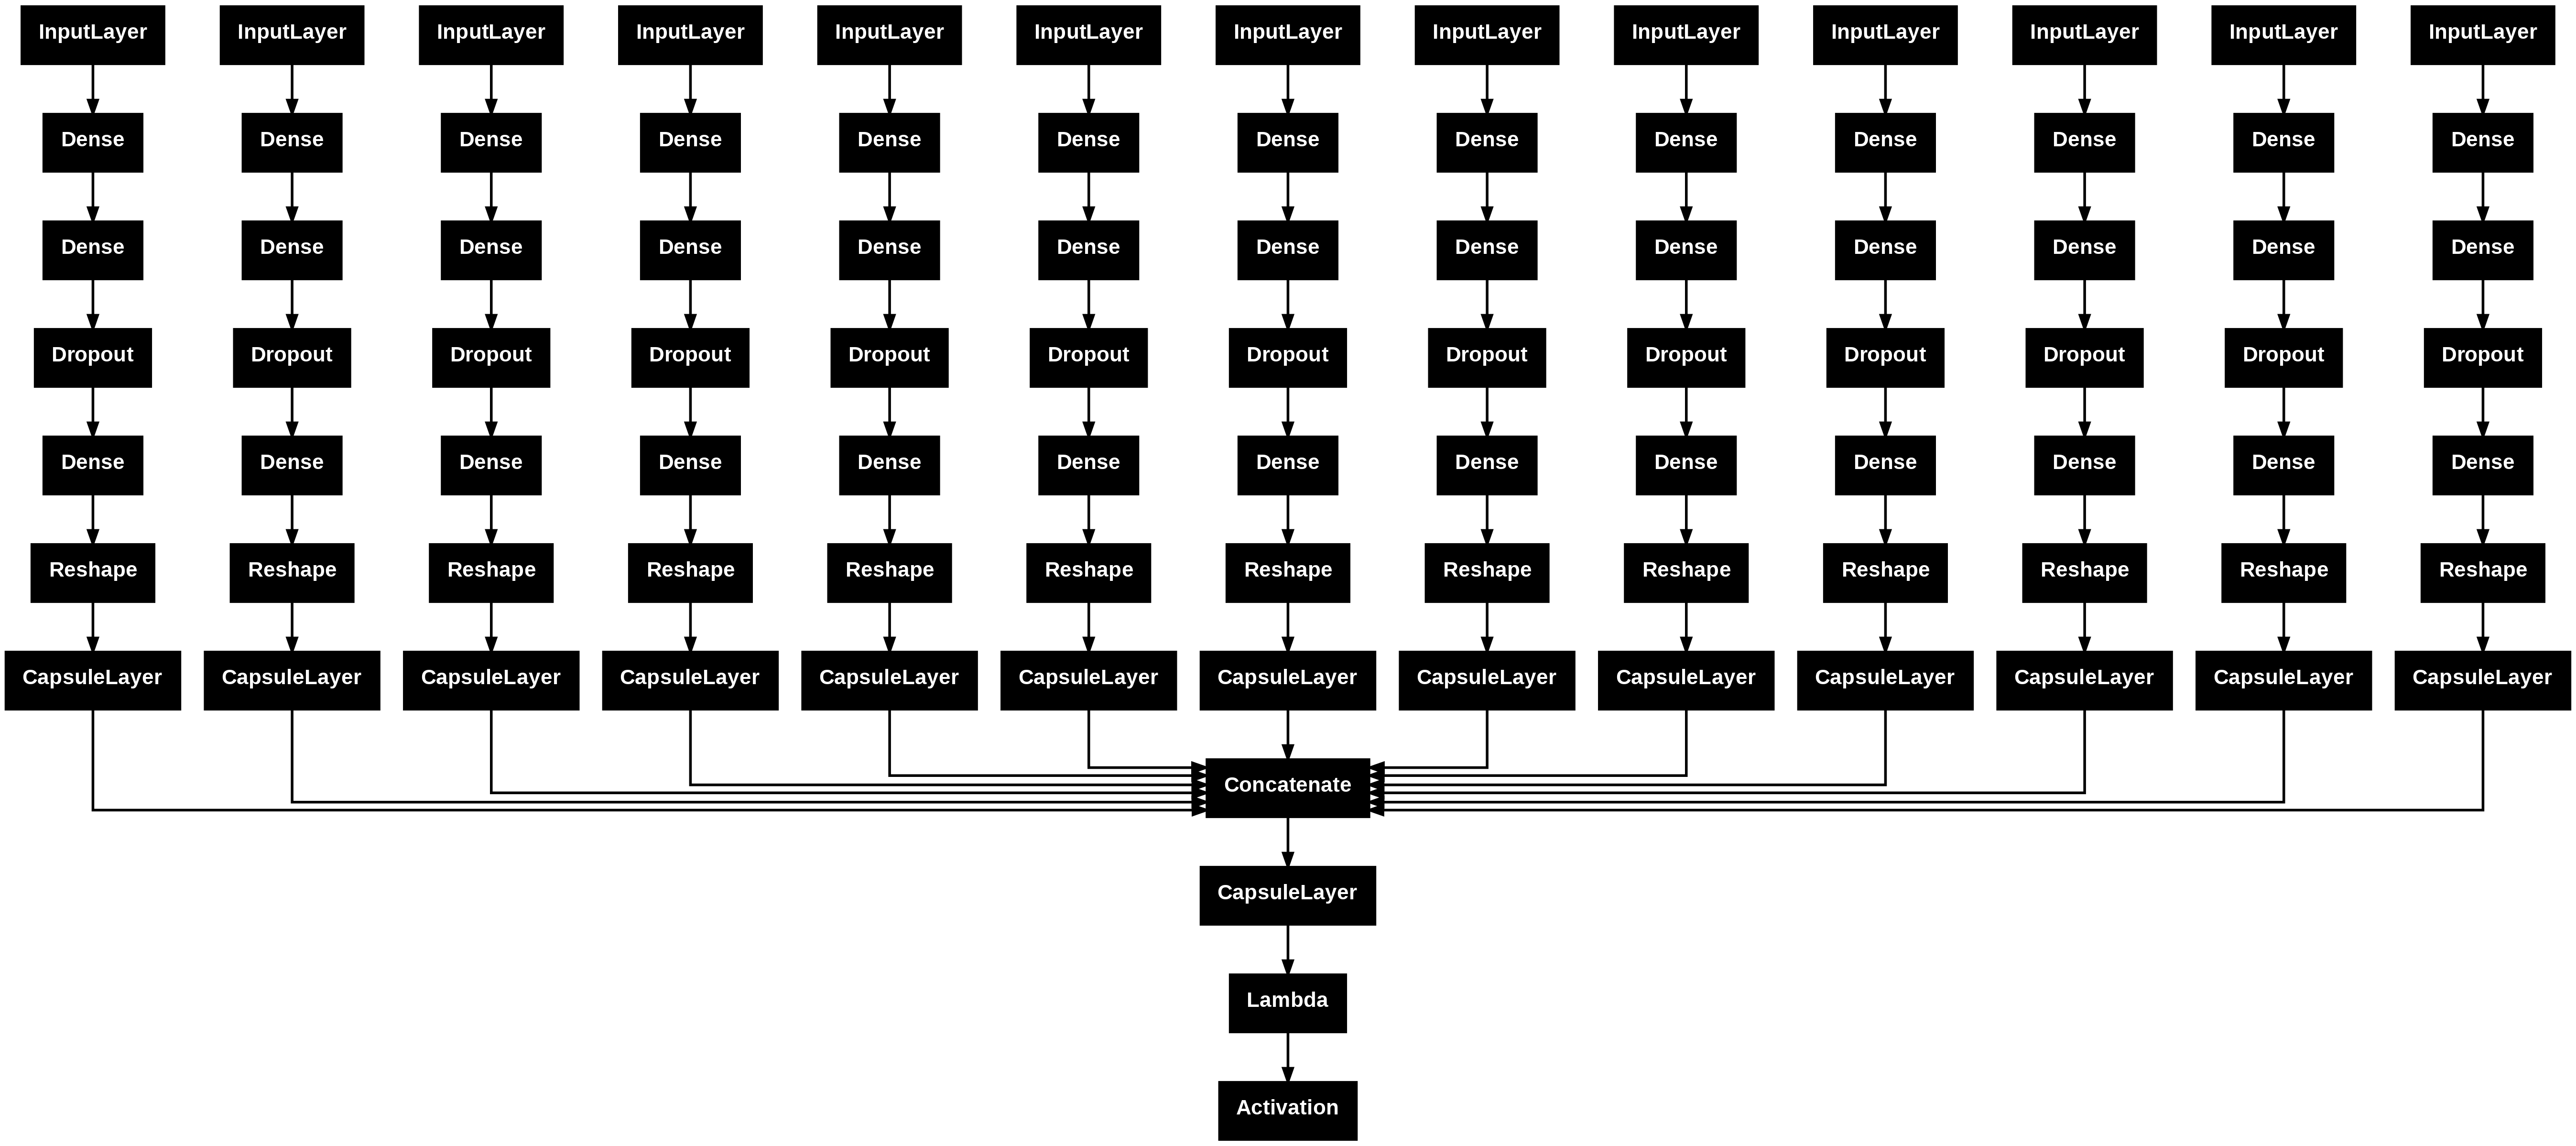

In [8]:
from keras.utils import plot_model
plot_model(model, 'taxo_capnet.png')

In [37]:
!zip -r saved_analysis.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/taxo_capnet.png (deflated 43%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/saved_model.h5 (deflated 89%)
  adding: kaggle/working/test_data.pkl (deflated 6%)
  adding: kaggle/working/capsule_model.keras (deflated 15%)
  adding: kaggle/working/taxonomy_map.pkl (deflated 73%)


# SHAP Analysis Capsule Networks

In [9]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Choose a test sample index
idx = 10  # Or any valid index
sample = [np.expand_dims(arr[idx], axis=0) for arr in X_test_list]  # Shape: [(1, feat1), (1, feat2), ...]

# Get prediction and ground truth
pred_probs = model.predict(sample)
pred_class = np.argmax(pred_probs)
true_class = y_test[idx]

print(f"Predicted class: {pred_class} (Prob: {pred_probs[0][pred_class]:.4f})")
print(f"True class: {true_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 0 (Prob: 0.7087)
True class: 0


In [10]:
len(y_test)

51

In [11]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf

class EnhancedTaxoShap:
    """
    Enhanced SHAP explainer with comprehensive visualizations and reasoning
    """

    def __init__(self, model,
                 sample: List[np.ndarray],
                 background_data: List[np.ndarray],
                 phylum_names: List[str],
                 taxonomy_map: Dict[str, List[str]] = None):
        """
        Args:
            model: Trained TaxoCaps model
            sample: The specific sample to explain (list of phylum arrays)
            background_data: Representative background data
            phylum_names: Names of phyla
            taxonomy_map: Optional phylum-to-OTU mapping
        """
        self.model = model
        self.sample = [x.copy() for x in sample]
        self.background_data = [x.copy() for x in background_data]
        self.phylum_names = phylum_names
        self.taxonomy_map = taxonomy_map or {}

        # Validate shapes
        for i, (s, bg) in enumerate(zip(self.sample, self.background_data)):
            if s.shape[1] != bg.shape[1]:
                raise ValueError(f"Phylum {i} dimension mismatch between sample and background")

        self.feature_names = self._create_feature_names()
        self.phylum_boundaries = self._calculate_phylum_boundaries()
        self.explanation_results = None

    def _create_feature_names(self) -> List[str]:
        """Generate feature names with graceful handling of missing taxonomy"""
        names = []
        for i, phylum in enumerate(self.phylum_names):
            try:
                clean_name = str(phylum).replace('p__', '').replace('_', ' ').strip() or f"Phylum_{i}"
                n_features = self.sample[i].shape[1]

                if phylum in self.taxonomy_map:
                    otus = self.taxonomy_map[phylum]
                    for j in range(n_features):
                        if j < len(otus):
                            names.append(f"{clean_name}_{otus[j]}")
                        else:
                            names.append(f"{clean_name}_OTU_{j}")
                else:
                    names.extend([f"{clean_name}_FT_{j}" for j in range(n_features)])
            except Exception as e:
                print(f"⚠️ Warning: Error naming features for phylum {phylum}: {str(e)}")
                names.extend([f"Feature_{i}_{j}" for j in range(self.sample[i].shape[1])])
        return names

    def _calculate_phylum_boundaries(self) -> List[Tuple[int, int]]:
        """Calculate phylum boundaries safely"""
        boundaries = []
        start = 0
        for arr in self.sample:
            if len(arr.shape) != 2:
                raise ValueError("Each phylum array must be 2D")
            end = start + arr.shape[1]
            boundaries.append((start, end))
            start = end
        return boundaries

    def _safe_predict(self, X_list: List[np.ndarray]) -> np.ndarray:
        """Safe prediction wrapper that handles TensorFlow shape issues"""
        try:
            pred = self.model.predict(X_list, verbose=0)
            if hasattr(pred, 'numpy'):
                pred = pred.numpy()
            pred = np.asarray(pred)
            if hasattr(pred, 'eval'):
                with tf.Session() as sess:
                    pred = pred.eval()
            return pred
        except Exception as e:
            print(f"⚠️ Prediction error: {e}")
            try:
                with tf.device('/CPU:0'):
                    pred = self.model(X_list, training=False)
                    if hasattr(pred, 'numpy'):
                        pred = pred.numpy()
                    return np.asarray(pred)
            except Exception as e2:
                print(f"⚠️ Alternative prediction also failed: {e2}")
                raise e

    def explain_comprehensive(self, method: str = "tree", n_background: int = 100) -> Dict[str, Any]:
        """Main explanation method with comprehensive analysis"""
        try:
            sample_flat = np.concatenate(self.sample, axis=1)
            background_flat = np.concatenate(self.background_data, axis=1)

            if method == "tree":
                results = self._tree_explanation(sample_flat, background_flat, n_background)
            elif method == "kernel":
                results = self._kernel_explanation(sample_flat, background_flat, n_background)
            else:
                raise ValueError("Method must be 'tree' or 'kernel'")
            
            # Add phylum-level analysis
            results.update(self._analyze_phylums(results['shap_values']))
            
            # Store results for further analysis
            self.explanation_results = results
            
            return results
            
        except Exception as e:
            print(f"❌ Explanation failed: {str(e)}")
            raise

    def _tree_explanation(self, sample: np.ndarray, background: np.ndarray, n_background: int) -> Dict[str, Any]:
        """Tree-based explanation with surrogate model"""
        print("🌳 Training surrogate model...")

        X_list = []
        for start, end in self.phylum_boundaries:
            X_list.append(background[:, start:end])
        
        preds = self._safe_predict(X_list)
        
        if len(preds.shape) == 1:
            labels = (preds > 0.5).astype(int)
        elif preds.shape[1] == 1:
            labels = (preds.flatten() > 0.5).astype(int)
        else:
            labels = np.argmax(preds, axis=1)

        surrogate = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        surrogate.fit(background, labels)

        explainer = shap.TreeExplainer(surrogate)
        shap_values = explainer.shap_values(sample)

        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]

        if isinstance(explainer.expected_value, (list, np.ndarray)):
            if len(explainer.expected_value) > 1:
                base_value = float(explainer.expected_value[1])
            else:
                base_value = float(explainer.expected_value[0])
        else:
            try:
                base_value = float(explainer.expected_value)
            except (TypeError, ValueError):
                base_value = float(np.array(explainer.expected_value).flatten()[0])

        return {
            'shap_values': np.array(shap_values[0]),
            'base_value': base_value,
            'sample_data': sample[0],
            'feature_names': self.feature_names,
            'method': 'tree',
            'surrogate_model': surrogate
        }

    def _kernel_explanation(self, sample: np.ndarray, background: np.ndarray, n_background: int) -> Dict[str, Any]:
        """Kernel SHAP explanation"""
        print("⚡ Using KernelSHAP...")
        explainer = shap.KernelExplainer(
            model=self._predict_wrapper,
            data=shap.sample(background, min(n_background, background.shape[0])),
            link="identity"
        )
        shap_values = explainer.shap_values(sample)

        try:
            base_value = float(explainer.expected_value)
        except (TypeError, ValueError):
            base_value = float(np.array(explainer.expected_value).flatten()[0])

        return {
            'shap_values': np.array(shap_values[0]),
            'base_value': base_value,
            'sample_data': sample[0],
            'feature_names': self.feature_names,
            'method': 'kernel'
        }

    def _predict_wrapper(self, X_flat: np.ndarray) -> np.ndarray:
        """Wrapper for safe prediction"""
        X_list = []
        for start, end in self.phylum_boundaries:
            X_list.append(X_flat[:, start:end])
        return self._safe_predict(X_list)

    def _analyze_phylums(self, shap_values: np.ndarray) -> Dict[str, Any]:
        """Analyze SHAP values at phylum level"""
        phylum_impacts = {}
        phylum_stats = {}
        
        for i, (phylum, (start, end)) in enumerate(zip(self.phylum_names, self.phylum_boundaries)):
            phylum_shap = shap_values[start:end]
            clean_name = str(phylum).replace('p__', '').replace('_', ' ').strip() or f"Phylum_{i}"
            
            phylum_impacts[clean_name] = {
                'total_impact': np.sum(phylum_shap),
                'mean_impact': np.mean(phylum_shap),
                'max_impact': np.max(phylum_shap),
                'min_impact': np.min(phylum_shap),
                'std_impact': np.std(phylum_shap),
                'positive_features': np.sum(phylum_shap > 0),
                'negative_features': np.sum(phylum_shap < 0),
                'feature_count': len(phylum_shap)
            }
            
        return {
            'phylum_impacts': phylum_impacts,
            'dominant_phylum': max(phylum_impacts.keys(), key=lambda x: abs(phylum_impacts[x]['total_impact'])),
            'most_positive_phylum': max(phylum_impacts.keys(), key=lambda x: phylum_impacts[x]['total_impact']),
            'most_negative_phylum': min(phylum_impacts.keys(), key=lambda x: phylum_impacts[x]['total_impact'])
        }

    def create_comprehensive_visualizations(self, max_display: int = 15):
        """Create comprehensive visualization suite"""
        if self.explanation_results is None:
            print("❌ Please run explain_comprehensive() first!")
            return
            
        results = self.explanation_results
        
        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Waterfall Plot
        plt.subplot(2, 3, 1)
        self._create_waterfall_plot(results, max_display)
        
        # 2. Feature Importance Bar Plot
        plt.subplot(2, 3, 2)
        self._create_feature_importance_plot(results, max_display)
        
        # 3. Phylum-level Impact
        plt.subplot(2, 3, 3)
        self._create_phylum_impact_plot(results)
        
        # 4. SHAP Value Distribution
        plt.subplot(2, 3, 4)
        self._create_shap_distribution_plot(results)
        
        # 5. Feature Impact Heatmap
        plt.subplot(2, 3, 5)
        self._create_impact_heatmap(results)
        
        # 6. Cumulative Impact Plot
        plt.subplot(2, 3, 6)
        self._create_cumulative_impact_plot(results)
        
        plt.tight_layout()
        plt.show()

    def _create_waterfall_plot(self, results: Dict[str, Any], max_display: int):
        """Create waterfall plot"""
        try:
            shap.plots.waterfall(
                shap.Explanation(
                    values=results['shap_values'],
                    base_values=results['base_value'],
                    data=results['sample_data'],
                    feature_names=results['feature_names']
                ),
                max_display=max_display,
                show=False
            )
            plt.title("SHAP Waterfall Plot")
        except Exception as e:
            plt.text(0.5, 0.5, f"Waterfall plot failed:\n{str(e)}", 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title("SHAP Waterfall Plot (Failed)")

    def _create_feature_importance_plot(self, results: Dict[str, Any], max_display: int):
        """Create feature importance bar plot"""
        values = results['shap_values']
        names = results['feature_names']
        
        # Get top features by absolute magnitude
        top_idx = np.argsort(np.abs(values))[::-1][:max_display]
        top_values = values[top_idx]
        top_names = [names[i][:30] + '...' if len(names[i]) > 30 else names[i] for i in top_idx]
        
        colors = ['red' if v < 0 else 'blue' for v in top_values]
        plt.barh(range(len(top_values)), top_values, color=colors)
        plt.yticks(range(len(top_values)), top_names)
        plt.xlabel("SHAP Value")
        plt.title("Top Feature Contributions")
        plt.gca().invert_yaxis()

    def _create_phylum_impact_plot(self, results: Dict[str, Any]):
        """Create phylum-level impact visualization"""
        phylum_impacts = results['phylum_impacts']
        
        phylums = list(phylum_impacts.keys())
        total_impacts = [phylum_impacts[p]['total_impact'] for p in phylums]
        
        colors = ['red' if v < 0 else 'green' for v in total_impacts]
        plt.barh(phylums, total_impacts, color=colors, alpha=0.7)
        plt.xlabel("Total SHAP Impact")
        plt.title("Phylum-Level Impact Analysis")
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

    def _create_shap_distribution_plot(self, results: Dict[str, Any]):
        """Create SHAP value distribution plot"""
        values = results['shap_values']
        
        plt.hist(values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(x=np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.4f}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, label='Baseline')
        plt.xlabel("SHAP Values")
        plt.ylabel("Frequency")
        plt.title("Distribution of SHAP Values")
        plt.legend()

    def _create_impact_heatmap(self, results: Dict[str, Any]):
        """Create impact heatmap by phylum"""
        shap_values = results['shap_values']
        
        # Create matrix for heatmap
        phylum_data = []
        phylum_labels = []
        
        for i, (phylum, (start, end)) in enumerate(zip(self.phylum_names, self.phylum_boundaries)):
            phylum_shap = shap_values[start:end]
            if len(phylum_shap) > 0:
                # Take top 5 features from each phylum for visualization
                top_indices = np.argsort(np.abs(phylum_shap))[-5:]
                phylum_data.extend(phylum_shap[top_indices])
                clean_name = str(phylum).replace('p__', '').strip()[:15]
                phylum_labels.extend([f"{clean_name}_{j}" for j in range(len(top_indices))])
        
        if len(phylum_data) > 0:
            # Reshape for heatmap
            data_matrix = np.array(phylum_data).reshape(-1, 1)
            
            sns.heatmap(data_matrix, 
                       yticklabels=phylum_labels,
                       xticklabels=['SHAP Impact'],
                       cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'SHAP Value'})
            plt.title("Feature Impact Heatmap")
            plt.xticks(rotation=45)
            plt.yticks(rotation=0, fontsize=8)

    def _create_cumulative_impact_plot(self, results: Dict[str, Any]):
        """Create cumulative impact plot"""
        values = results['shap_values']
        
        # Sort by absolute value
        sorted_indices = np.argsort(np.abs(values))[::-1]
        sorted_values = values[sorted_indices]
        
        cumulative_impact = np.cumsum(sorted_values)
        
        plt.plot(range(len(cumulative_impact)), cumulative_impact, marker='o', markersize=2)
        plt.xlabel("Feature Rank (by |SHAP|)")
        plt.ylabel("Cumulative SHAP Impact")
        plt.title("Cumulative Feature Impact")
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)

    def generate_reasoning_report(self) -> str:
        """Generate detailed reasoning report"""
        if self.explanation_results is None:
            return "❌ Please run explain_comprehensive() first!"
        
        results = self.explanation_results
        report = []
        
        # Get model prediction
        try:
            sample_input = [np.array(x) for x in self.sample]
            pred = self._safe_predict(sample_input)
            
            if pred.ndim == 1:
                pred_prob = float(pred[0]) if len(pred) == 1 else float(pred[np.argmax(pred)])
                pred_class = int(pred[0] > 0.5) if len(pred) == 1 else int(np.argmax(pred))
            elif pred.shape[1] == 1:
                pred_prob = float(pred[0, 0])
                pred_class = int(pred[0, 0] > 0.5)
            elif pred.shape[1] == 2:
                pred_prob = float(pred[0, 1])
                pred_class = int(pred[0, 1] > 0.5)
            else:
                pred_class = int(np.argmax(pred[0]))
                pred_prob = float(pred[0, pred_class])
        except Exception as e:
            pred_prob = "Error"
            pred_class = "Error"
        
        report.append("🔬 **TAXONOMIC MICROBIOME PREDICTION ANALYSIS REPORT**")
        report.append("=" * 60)
        
        # 1. Prediction Summary
        report.append("\n📊 **PREDICTION SUMMARY**")
        report.append(f"   • Model Prediction: Class {pred_class}")
        report.append(f"   • Confidence: {pred_prob:.4f}" if pred_prob != "Error" else f"   • Confidence: {pred_prob}")
        report.append(f"   • Explanation Method: {results['method'].upper()}")
        report.append(f"   • Base Value: {results['base_value']:.4f}")
        
        # 2. Feature Analysis
        shap_values = results['shap_values']
        report.append(f"\n🧬 **FEATURE IMPACT ANALYSIS**")
        report.append(f"   • Total Features Analyzed: {len(shap_values)}")
        report.append(f"   • Mean SHAP Impact: {np.mean(shap_values):.4f}")
        report.append(f"   • SHAP Impact Range: [{np.min(shap_values):.4f}, {np.max(shap_values):.4f}]")
        report.append(f"   • Features with Positive Impact: {np.sum(shap_values > 0)}")
        report.append(f"   • Features with Negative Impact: {np.sum(shap_values < 0)}")
        
        # 3. Top Contributors
        top_positive_idx = np.argsort(shap_values)[-3:][::-1]
        top_negative_idx = np.argsort(shap_values)[:3]
        
        report.append(f"\n🌟 **TOP POSITIVE CONTRIBUTORS** (Supporting Prediction)")
        for idx in top_positive_idx:
            if shap_values[idx] > 0:
                report.append(f"   • {results['feature_names'][idx]}: {shap_values[idx]:.4f}")
        
        report.append(f"\n⚠️ **TOP NEGATIVE CONTRIBUTORS** (Against Prediction)")
        for idx in top_negative_idx:
            if shap_values[idx] < 0:
                report.append(f"   • {results['feature_names'][idx]}: {shap_values[idx]:.4f}")
        
        # 4. Phylum Analysis
        if 'phylum_impacts' in results:
            phylum_impacts = results['phylum_impacts']
            report.append(f"\n🦠 **PHYLUM-LEVEL ANALYSIS**")
            report.append(f"   • Dominant Phylum: {results['dominant_phylum']}")
            report.append(f"   • Most Supportive: {results['most_positive_phylum']}")
            report.append(f"   • Most Contradictory: {results['most_negative_phylum']}")
            
            report.append(f"\n   **Detailed Phylum Impacts:**")
            sorted_phylums = sorted(phylum_impacts.keys(), 
                                  key=lambda x: abs(phylum_impacts[x]['total_impact']), 
                                  reverse=True)
            
            for phylum in sorted_phylums[:5]:  # Top 5 phylums
                impact = phylum_impacts[phylum]
                report.append(f"   • {phylum}:")
                report.append(f"     - Total Impact: {impact['total_impact']:.4f}")
                report.append(f"     - Features: {impact['feature_count']} ({impact['positive_features']}+, {impact['negative_features']}-)")
                report.append(f"     - Impact Range: [{impact['min_impact']:.4f}, {impact['max_impact']:.4f}]")
        
        return "\n".join(report)

    def generate_conclusions(self) -> str:
        """Generate final conclusions"""
        if self.explanation_results is None:
            return "❌ Please run explain_comprehensive() first!"
        
        results = self.explanation_results
        conclusions = []
        
        conclusions.append("🎯 **FINAL CONCLUSIONS & INSIGHTS**")
        conclusions.append("=" * 50)
        
        # Statistical insights
        shap_values = results['shap_values']
        strong_features = np.sum(np.abs(shap_values) > np.std(shap_values))
        
        conclusions.append(f"\n**Key Findings:**")
        conclusions.append(f"• {strong_features} features show strong predictive signal (>1 std)")
        conclusions.append(f"• {np.sum(shap_values > 0)} features support the prediction")
        conclusions.append(f"• {np.sum(shap_values < 0)} features contradict the prediction")
        
        # Phylum insights
        if 'phylum_impacts' in results:
            phylum_impacts = results['phylum_impacts']
            total_phylums = len(phylum_impacts)
            active_phylums = sum(1 for p in phylum_impacts.values() if abs(p['total_impact']) > 0.001)
            
            conclusions.append(f"\n**Taxonomic Insights:**")
            conclusions.append(f"• {active_phylums}/{total_phylums} phylums show significant impact")
            conclusions.append(f"• Primary driver: {results['dominant_phylum']} phylum")
            
            # Determine prediction confidence
            total_positive = sum(p['total_impact'] for p in phylum_impacts.values() if p['total_impact'] > 0)
            total_negative = sum(p['total_impact'] for p in phylum_impacts.values() if p['total_impact'] < 0)
            confidence_ratio = abs(total_positive) / (abs(total_negative) + 1e-8)
            
            if confidence_ratio > 2:
                confidence_level = "High"
            elif confidence_ratio > 1.5:
                confidence_level = "Moderate"
            else:
                confidence_level = "Low"
            
            conclusions.append(f"• Prediction Confidence Level: {confidence_level}")
            conclusions.append(f"• Evidence Ratio: {confidence_ratio:.2f}:1 (positive:negative)")
        
        conclusions.append(f"\n**Biological Interpretation:**")
        
        # Get most impactful features for biological interpretation
        top_features_idx = np.argsort(np.abs(shap_values))[-5:][::-1]
        dominant_features = [results['feature_names'][idx] for idx in top_features_idx]
        
        conclusions.append(f"• Key microbial signatures identified: {len(dominant_features)} primary features")
        conclusions.append(f"• Model decision primarily driven by taxonomic features from:")
        
        # Group by phylum
        feature_phylums = {}
        for feature in dominant_features:
            phylum_name = feature.split('_')[0]
            if phylum_name not in feature_phylums:
                feature_phylums[phylum_name] = 0
            feature_phylums[phylum_name] += 1
        
        for phylum, count in sorted(feature_phylums.items(), key=lambda x: x[1], reverse=True):
            conclusions.append(f"  - {phylum}: {count} influential features")
        
        conclusions.append(f"\n**Recommendations:**")
        conclusions.append(f"• Focus analysis on {results['dominant_phylum']} for biological validation")
        conclusions.append(f"• Investigate interaction between top positive and negative contributors")
        conclusions.append(f"• Consider feature stability across different samples")
        
        return "\n".join(conclusions)

    def full_analysis_report(self, max_display: int = 15):
        """Generate complete analysis with visualizations and reasoning"""
        print("🚀 Starting Comprehensive TaxoSHAP Analysis...")
        
        # 1. Generate explanations
        results = self.explain_comprehensive()
        
        # 2. Create visualizations
        print("\n📊 Creating Comprehensive Visualizations...")
        self.create_comprehensive_visualizations(max_display)
        
        # 3. Generate reasoning report
        print("\n📝 Generating Reasoning Report...")
        reasoning = self.generate_reasoning_report()
        print(reasoning)
        
        # 4. Generate conclusions
        print("\n🎯 Generating Final Conclusions...")
        conclusions = self.generate_conclusions()
        print(conclusions)
        
        return {
            'explanation_results': results,
            'reasoning_report': reasoning,
            'conclusions': conclusions
        }


# Usage Example:
"""
# Initialize enhanced explainer
enhanced_explainer = EnhancedTaxoShap(
    model=model,
    sample=sample,
    background_data=background,
    phylum_names=used_phyla,
    # taxonomy_map=taxonomy_map
)

# Run complete analysis
full_report = enhanced_explainer.full_analysis_report(max_display=20)
"""


'\n# Initialize enhanced explainer\nenhanced_explainer = EnhancedTaxoShap(\n    model=model,\n    sample=sample,\n    background_data=background,\n    phylum_names=used_phyla,\n    # taxonomy_map=taxonomy_map\n)\n\n# Run complete analysis\nfull_report = enhanced_explainer.full_analysis_report(max_display=20)\n'

🚀 Starting Comprehensive TaxoSHAP Analysis...
🌳 Training surrogate model...

📊 Creating Comprehensive Visualizations...


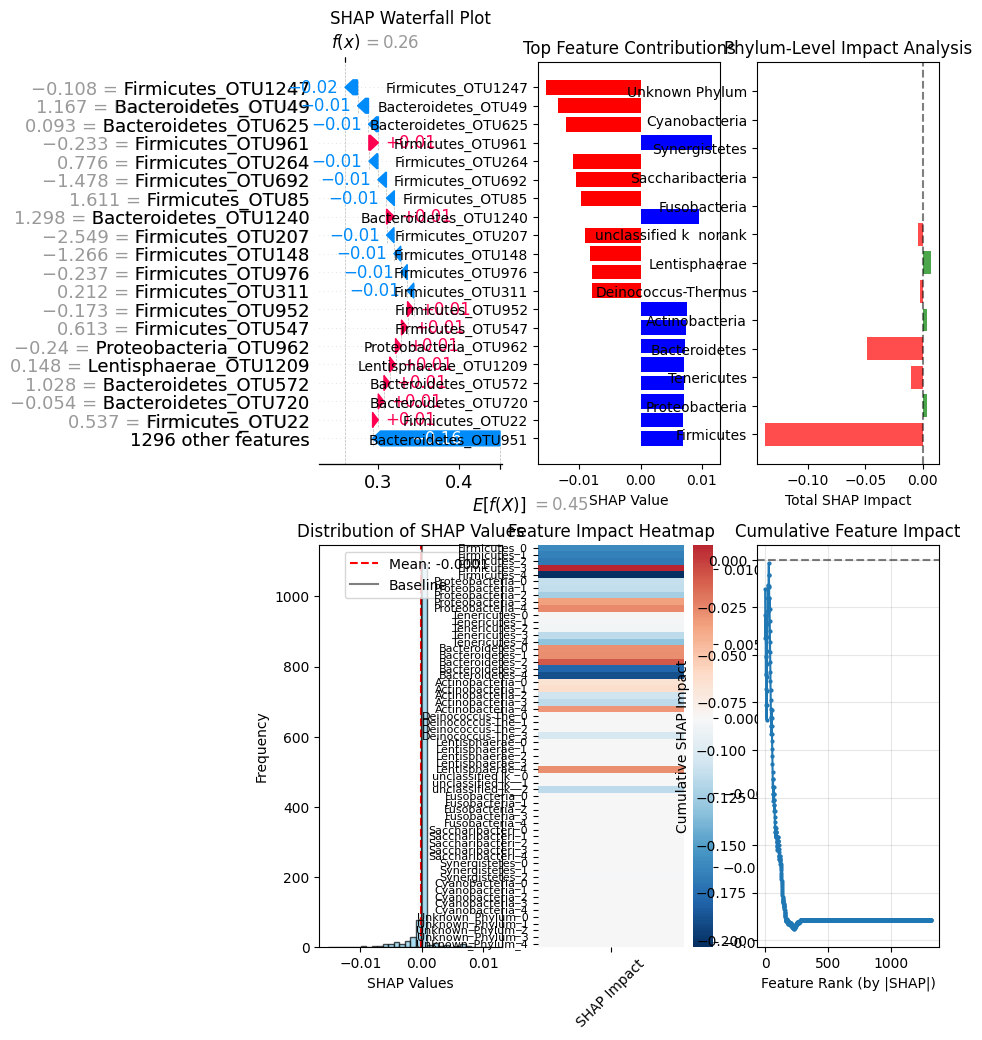


📝 Generating Reasoning Report...
🔬 **TAXONOMIC MICROBIOME PREDICTION ANALYSIS REPORT**

📊 **PREDICTION SUMMARY**
   • Model Prediction: Class 0
   • Confidence: 0.3075
   • Explanation Method: TREE
   • Base Value: 0.4496

🧬 **FEATURE IMPACT ANALYSIS**
   • Total Features Analyzed: 1315
   • Mean SHAP Impact: -0.0001
   • SHAP Impact Range: [-0.0153, 0.0117]
   • Features with Positive Impact: 126
   • Features with Negative Impact: 177

🌟 **TOP POSITIVE CONTRIBUTORS** (Supporting Prediction)
   • Firmicutes_OTU961: 0.0117
   • Bacteroidetes_OTU1240: 0.0095
   • Firmicutes_OTU952: 0.0075

⚠️ **TOP NEGATIVE CONTRIBUTORS** (Against Prediction)
   • Firmicutes_OTU1247: -0.0153
   • Bacteroidetes_OTU49: -0.0134
   • Bacteroidetes_OTU625: -0.0121

🦠 **PHYLUM-LEVEL ANALYSIS**
   • Dominant Phylum: Firmicutes
   • Most Supportive: Lentisphaerae
   • Most Contradictory: Firmicutes

   **Detailed Phylum Impacts:**
   • Firmicutes:
     - Total Impact: -0.1374
     - Features: 812 (82+, 110-)
 

In [12]:
# Run the complete analysis
sample_idx = 4 # The sample you want to explain
background_size = 50 # Number of samples to use as background

# Extract single sample (keep phylum structure)
sample = [arr[[sample_idx]] for arr in X_test_list]

# Create background (random subset of test data)
background_indices = np.random.choice(len(X_test_list[0]), background_size, replace=False)
background = [arr[background_indices] for arr in X_test_list]

enhanced_explainer = EnhancedTaxoShap(model, sample, background, used_phyla, taxonomy_map)
full_report = enhanced_explainer.full_analysis_report(max_display=20)


In [13]:
full_report.keys()

dict_keys(['explanation_results', 'reasoning_report', 'conclusions'])

# Flask Server

In [14]:
pip install -q flask_cors 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# app.py (Updated TaxoShapServer class only)
import os
import io
import base64
import traceback
import json
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, send_file
from flask_cors import CORS
import logging
from datetime import datetime
import pickle
import tempfile
from typing import Dict, Any, List
import uuid

app = Flask(__name__)
CORS(app)  # Enable CORS for frontend integration

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class TaxoShapServer:
    """Flask server for TaxoSHAP analysis using real test data indices"""
    
    def __init__(self):
        self.model = None
        self.X_test_list = None  # Your actual test data (list of numpy arrays)
        self.y_test = None       # Test labels (optional)
        self.phylums = None      # Phylum names
        self.taxonomy_map = None # Taxonomy mapping
        self.available_samples = {}  # Will store sample indices with metadata
        self.temp_images = {}    # Store temporary image files
        
    def initialize_model_and_data(self, model_path: str = None, test_data_path: str = None, 
                                 X_test_list=None, phylums=None, taxonomy_map=None, y_test=None):
        """Initialize model and test data from your actual test dataset"""
        try:
            # Load your trained model (adjust path as needed)
            if model_path and os.path.exists(model_path):
                import tensorflow as tf
                self.model = tf.keras.models.load_model(model_path)
                logger.info(f"✅ Model loaded from {model_path}")
            elif self.model is None:
                logger.warning("⚠️ Model not provided. Set it externally.")
                
            # Load test data from provided variables or file
            if X_test_list is not None:
                self.X_test_list = X_test_list
                self.phylums = phylums
                self.taxonomy_map = taxonomy_map or {}
                self.y_test = y_test
                logger.info("✅ Test data loaded from provided variables")
                
            elif test_data_path and os.path.exists(test_data_path):
                with open(test_data_path, 'rb') as f:
                    test_data = pickle.load(f)
                    self.X_test_list = test_data.get('X_test_list', None)
                    self.phylums = test_data.get('phylums', [])
                    self.taxonomy_map = test_data.get('taxonomy_map', {})
                    self.y_test = test_data.get('y_test', None)
                logger.info(f"✅ Test data loaded from {test_data_path}")
                
            else:
                raise ValueError("No test data provided. Please provide X_test_list or test_data_path")
            
            # Validate test data
            if self.X_test_list is None or len(self.X_test_list) == 0:
                raise ValueError("X_test_list is empty or None")
            
            # Create available samples from test data indices
            self.create_sample_indices()
                
        except Exception as e:
            logger.error(f"❌ Initialization failed: {str(e)}")
            raise e
    
    def create_sample_indices(self, num_samples: int = 20):
        """Create available sample indices from actual test data"""
        try:
            if self.X_test_list is None:
                raise ValueError("Test data not loaded")
            
            # Get the number of samples in test data (assuming all phylums have same sample count)
            total_samples = self.X_test_list[0].shape[0]
            logger.info(f"📊 Total test samples available: {total_samples}")
            
            # Select random indices for available samples
            np.random.seed(42)  # For reproducible results
            if num_samples > total_samples:
                selected_indices = list(range(total_samples))
            else:
                selected_indices = np.random.choice(total_samples, size=num_samples, replace=False)
            
            # Create sample metadata
            for i, idx in enumerate(selected_indices):
                sample_id = f"sample_{idx}"  # Use actual test index
                
                # Get sample statistics for description
                sample_stats = self.get_sample_statistics(idx)
                
                self.available_samples[sample_id] = {
                    'test_index': int(idx),  # Actual test data index
                    'sample_number': i,      # Sequential number for display
                    'description': f"Test sample from index {idx}",
                    'metadata': {
                        'test_index': int(idx),
                        'total_features': sample_stats['total_features'],
                        'phylums_count': len(self.phylums) if self.phylums else len(self.X_test_list),
                        'feature_distribution': sample_stats['phylum_features'],
                        'true_label': int(self.y_test[idx]) if self.y_test is not None else None
                    },
                    'statistics': sample_stats
                }
            
            logger.info(f"✅ Created {len(self.available_samples)} available samples from test indices")
            
        except Exception as e:
            logger.error(f"❌ Failed to create sample indices: {str(e)}")
            raise e
    
    def get_sample_statistics(self, test_index: int) -> Dict[str, Any]:
        """Get statistics for a specific test sample"""
        try:
            stats = {
                'total_features': 0,
                'phylum_features': {},
                'data_shapes': [],
                'feature_ranges': {}
            }
            
            for i, phylum_data in enumerate(self.X_test_list):
                phylum_name = self.phylums[i] if self.phylums and i < len(self.phylums) else f"Phylum_{i}"
                sample_data = phylum_data[test_index]
                
                # Clean phylum name
                clean_name = str(phylum_name).replace('p__', '').replace('_', ' ').strip()
                
                stats['phylum_features'][clean_name] = int(phylum_data.shape[1])
                stats['total_features'] += int(phylum_data.shape[1])
                stats['data_shapes'].append(list(phylum_data.shape))
                
                # Feature value statistics for this sample
                stats['feature_ranges'][clean_name] = {
                    'min': float(np.min(sample_data)),
                    'max': float(np.max(sample_data)),
                    'mean': float(np.mean(sample_data)),
                    'std': float(np.std(sample_data))
                }
            
            return stats
            
        except Exception as e:
            logger.warning(f"⚠️ Failed to get statistics for sample {test_index}: {str(e)}")
            return {'total_features': 0, 'phylum_features': {}, 'data_shapes': [], 'feature_ranges': {}}
    
    def get_sample_data(self, sample_id: str) -> List[np.ndarray]:
        """Get actual sample data for SHAP analysis"""
        if sample_id not in self.available_samples:
            raise ValueError(f"Sample {sample_id} not found")
        
        test_index = self.available_samples[sample_id]['test_index']
        
        # Extract sample data for each phylum (keep as single sample with batch dimension)
        sample_data = []
        for phylum_data in self.X_test_list:
            # Get single sample but keep 2D shape for consistency
            single_sample = phylum_data[test_index:test_index+1]  # Shape: (1, features)
            sample_data.append(single_sample)
        
        return sample_data
    
    def get_background_data(self, exclude_sample_id: str, n_background: int = 50) -> List[np.ndarray]:
        """Get background data excluding the target sample"""
        exclude_index = self.available_samples[exclude_sample_id]['test_index']
        
        # Get total samples available
        total_samples = self.X_test_list[0].shape[0]
        
        # Create indices excluding the target sample
        all_indices = list(range(total_samples))
        all_indices.remove(exclude_index)
        
        # Select random background indices
        if len(all_indices) < n_background:
            background_indices = all_indices
            logger.warning(f"⚠️ Only {len(all_indices)} background samples available, using all")
        else:
            background_indices = np.random.choice(all_indices, size=n_background, replace=False)
        
        # Extract background data
        background_data = []
        for phylum_data in self.X_test_list:
            background_samples = phylum_data[background_indices]
            background_data.append(background_samples)
        
        return background_data

# Initialize server instance
server = TaxoShapServer()

with app.app_context():
# def startup():
    """Initialize model and data on startup"""
    try:
        # You can specify paths here or set them via environment variables
        model_path = "/kaggle/input/utils-capsnets/model/capsule_model.keras"
        # test_data_path = "/kaggle/input/utils-capsnets/model/test_data.pkl"
        
        # If you have the variables available, you can pass them directly:
        server.initialize_model_and_data(
            model_path=model_path,
            X_test_list=X_test_list,  # Your actual test data
            phylums=used_phyla,       # Your phylum names
            taxonomy_map=taxonomy_map,# Your taxonomy mapping
            y_test=y_test            # Your test labels (optional)
        )
        
        # For now, trying to load from file or environment
        server.initialize_model_and_data(model_path, test_data_path)
        
    except Exception as e:
        logger.error(f"❌ Startup failed: {str(e)}")

# # Update the analyze endpoint to use the new methods
# @app.route('/analyze', methods=['POST'])
# def analyze_sample():
#     """Main endpoint for SHAP analysis using real test data"""
#     analysis_id = str(uuid.uuid4())
#     logger.info(f"🔍 Starting analysis {analysis_id}")
    
#     try:
#         # Parse request data
#         data = request.get_json()
#         if not data:
#             return jsonify({
#                 'status': 'error',
#                 'message': 'No JSON data provided'
#             }), 400
        
#         sample_id = data.get('sample_id')
#         method = data.get('method', 'tree')  # 'tree' or 'kernel'
#         max_display = data.get('max_display', 15)
#         n_background = data.get('n_background', 50)
        
#         if not sample_id:
#             return jsonify({
#                 'status': 'error',
#                 'message': 'sample_id is required'
#             }), 400
        
#         if sample_id not in server.available_samples:
#             return jsonify({
#                 'status': 'error',
#                 'message': f'Sample {sample_id} not found'
#             }), 404
        
#         if server.model is None:
#             return jsonify({
#                 'status': 'error',
#                 'message': 'Model not loaded'
#             }), 500
        
#         # Get actual sample data from test set
#         sample_data = server.get_sample_data(sample_id)
#         background_data = server.get_background_data(sample_id, n_background)
        
#         logger.info(f"🧬 Using test index {server.available_samples[sample_id]['test_index']} for analysis {analysis_id}")
        
#         # Initialize EnhancedTaxoShap with real test data
#         explainer = EnhancedTaxoShap(
#             model=server.model,
#             sample=sample_data,
#             background_data=background_data,
#             phylum_names=server.phylums or [f"Phylum_{i}" for i in range(len(sample_data))],
#             taxonomy_map=server.taxonomy_map
#         )
        
#         logger.info(f"🔬 Running SHAP analysis for {analysis_id}")
        
#         # Run comprehensive analysis
#         results = explainer.explain_comprehensive(method=method, n_background=n_background)
        
#         # Generate reasoning report
#         reasoning_report = explainer.generate_reasoning_report()
#         conclusions = explainer.generate_conclusions()
        
#         logger.info(f"📊 Generating visualizations for {analysis_id}")
        
#         # Generate visualizations and save as base64 images
#         plt.ioff()  # Turn off interactive plotting
#         visualization_images = generate_visualization_images(explainer, results, max_display, analysis_id)
        
#         # Get true prediction for comparison (if available)
#         true_label = server.available_samples[sample_id]['metadata'].get('true_label', None)
        
#         # Compile response
#         response_data = {
#             'status': 'success',
#             'analysis_id': analysis_id,
#             'sample_id': sample_id,
#             'test_index': server.available_samples[sample_id]['test_index'],
#             'true_label': true_label,
#             'method': method,
#             'timestamp': datetime.now().isoformat(),
#             'sample_info': server.available_samples[sample_id],
#             'shap_results': {
#                 'base_value': float(results['base_value']),
#                 'feature_count': len(results['feature_names']),
#                 'shap_values_stats': {
#                     'mean': float(np.mean(results['shap_values'])),
#                     'std': float(np.std(results['shap_values'])),
#                     'min': float(np.min(results['shap_values'])),
#                     'max': float(np.max(results['shap_values']))
#                 },
#                 'top_positive_features': get_top_features(results, positive=True),
#                 'top_negative_features': get_top_features(results, positive=False),
#                 'phylum_analysis': results.get('phylum_impacts', {})
#             },
#             'reasoning_report': reasoning_report,
#             'conclusions': conclusions,
#             'visualizations': visualization_images
#         }
        
#         logger.info(f"✅ Analysis {analysis_id} completed successfully for test index {server.available_samples[sample_id]['test_index']}")
#         return jsonify(response_data), 200
        
#     except Exception as e:
#         logger.error(f"❌ Analysis failed: {str(e)}")
#         logger.error(traceback.format_exc())
#         return jsonify({
#             'status': 'error',
#             'message': str(e),
#             'analysis_id': analysis_id,
#             'timestamp': datetime.now().isoformat()
#         }), 500

# Update the samples endpoint to show real test data info
@app.route('/samples', methods=['GET'])
def get_available_samples():
    """Get list of available test samples with real indices"""
    try:
        samples_info = {}
        for sample_id, sample_data in server.available_samples.items():
            samples_info[sample_id] = {
                'test_index': sample_data['test_index'],
                'description': sample_data['description'],
                'metadata': sample_data['metadata'],
                'statistics': sample_data['statistics']
            }
        
        return jsonify({
            'status': 'success',
            'samples': samples_info,
            'total_count': len(samples_info),
            'total_test_samples': server.X_test_list[0].shape[0] if server.X_test_list else 0
        }), 200
        
    except Exception as e:
        logger.error(f"Get samples failed: {str(e)}")
        return jsonify({
            'status': 'error',
            'message': str(e)
        }), 500


@app.route('/samples/<sample_id>/info', methods=['GET'])
def get_sample_info(sample_id):
    """Get detailed information about a specific sample"""
    try:
        if sample_id not in server.test_samples:
            return jsonify({
                'status': 'error',
                'message': f'Sample {sample_id} not found'
            }), 404
        
        sample_data = server.test_samples[sample_id]
        
        info = {
            'sample_id': sample_id,
            'description': sample_data.get('description', 'No description'),
            'metadata': sample_data.get('metadata', {}),
            'phylum_details': []
        }
        
        # Add phylum-specific details
        for i, (phylum, data_array) in enumerate(zip(server.phylums or [], sample_data['data'])):
            info['phylum_details'].append({
                'phylum_name': phylum,
                'feature_count': data_array.shape[1],
                'data_shape': list(data_array.shape)
            })
        
        return jsonify({
            'status': 'success',
            'sample_info': info
        }), 200
        
    except Exception as e:
        logger.error(f"Get sample info failed: {str(e)}")
        return jsonify({
            'status': 'error',
            'message': str(e)
        }), 500


# Remove the first analyze_sample endpoint (lines 411-500) and keep only the second one

@app.route('/analyze', methods=['POST'])
def analyze_sample():
    """Main endpoint for SHAP analysis using real test data"""
    analysis_id = str(uuid.uuid4())
    logger.info(f"🔍 Starting analysis {analysis_id}")
    
    try:
        # Parse request data
        data = request.get_json()
        if not data:
            return jsonify({
                'status': 'error',
                'message': 'No JSON data provided'
            }), 400
        
        sample_id = data.get('sample_id')
        method = data.get('method', 'tree')
        max_display = data.get('max_display', 15)
        n_background = data.get('n_background', 50)
        
        if not sample_id:
            return jsonify({
                'status': 'error',
                'message': 'sample_id is required'
            }), 400
        
        if sample_id not in server.available_samples:
            return jsonify({
                'status': 'error',
                'message': f'Sample {sample_id} not found'
            }), 404
        
        if server.model is None:
            return jsonify({
                'status': 'error',
                'message': 'Model not loaded'
            }), 500
        
        # Get actual sample data from test set
        sample_data = server.get_sample_data(sample_id)
        background_data = server.get_background_data(sample_id, n_background)
        
        logger.info(f"🧬 Using test index {server.available_samples[sample_id]['test_index']} for analysis {analysis_id}")
        
        # Initialize EnhancedTaxoShap with real test data
        explainer = EnhancedTaxoShap(
            model=server.model,
            sample=sample_data,
            background_data=background_data,
            phylum_names=server.phylums or [f"Phylum_{i}" for i in range(len(sample_data))],
            taxonomy_map=server.taxonomy_map
        )
        
        logger.info(f"🔬 Running SHAP analysis for {analysis_id}")
        
        # Run comprehensive analysis
        results = explainer.explain_comprehensive(method=method, n_background=n_background)
        
        # Generate reasoning report
        reasoning_report = explainer.generate_reasoning_report()
        conclusions = explainer.generate_conclusions()
        
        logger.info(f"📊 Generating visualizations for {analysis_id}")
        
        # Generate visualizations and save as base64 images
        plt.ioff()
        visualization_images = generate_visualization_images(explainer, results, max_display, analysis_id)
        
        # Get true prediction for comparison (if available)
        true_label = server.available_samples[sample_id]['metadata'].get('true_label', None)
        
        # Compile response
        response_data = {
            'status': 'success',
            'analysis_id': analysis_id,
            'sample_id': sample_id,
            'test_index': server.available_samples[sample_id]['test_index'],
            'true_label': true_label,
            'method': method,
            'timestamp': datetime.now().isoformat(),
            'sample_info': server.available_samples[sample_id],
            'shap_results': {
                'base_value': float(results['base_value']),
                'feature_count': len(results['feature_names']),
                'shap_values_stats': {
                    'mean': float(np.mean(results['shap_values'])),
                    'std': float(np.std(results['shap_values'])),
                    'min': float(np.min(results['shap_values'])),
                    'max': float(np.max(results['shap_values']))
                },
                'top_positive_features': get_top_features(results, positive=True),
                'top_negative_features': get_top_features(results, positive=False),
                'phylum_analysis': results.get('phylum_impacts', {})
            },
            'reasoning_report': reasoning_report,
            'conclusions': conclusions,
            'visualizations': visualization_images
        }
        
        logger.info(f"✅ Analysis {analysis_id} completed successfully for test index {server.available_samples[sample_id]['test_index']}")
        return jsonify(response_data), 200
        
    except Exception as e:
        logger.error(f"❌ Analysis failed: {str(e)}")
        logger.error(traceback.format_exc())
        return jsonify({
            'status': 'error',
            'message': str(e),
            'analysis_id': analysis_id,
            'timestamp': datetime.now().isoformat()
        }), 500


def get_top_features(results: Dict[str, Any], positive: bool = True, top_n: int = 5) -> List[Dict]:
    """Extract top positive or negative features"""
    shap_values = results['shap_values']
    feature_names = results['feature_names']
    
    if positive:
        indices = np.argsort(shap_values)[-top_n:][::-1]
        indices = indices[shap_values[indices] > 0]
    else:
        indices = np.argsort(shap_values)[:top_n]
        indices = indices[shap_values[indices] < 0]
    
    return [
        {
            'feature_name': feature_names[idx],
            'shap_value': float(shap_values[idx]),
            'rank': int(rank + 1)
        }
        for rank, idx in enumerate(indices)
    ]

def generate_visualization_images(explainer, results: Dict[str, Any], max_display: int, analysis_id: str) -> Dict[str, str]:
    """Generate visualization images and return as base64 encoded strings"""[7]
    images = {}
    
    try:
        # 1. Feature Importance Bar Plot
        plt.figure(figsize=(12, 8))
        values = results['shap_values']
        names = results['feature_names']
        
        top_idx = np.argsort(np.abs(values))[::-1][:max_display]
        top_values = values[top_idx]
        top_names = [names[i][:30] + '...' if len(names[i]) > 30 else names[i] for i in top_idx]
        
        colors = ['red' if v < 0 else 'blue' for v in top_values]
        plt.barh(range(len(top_values)), top_values, color=colors, alpha=0.7)
        plt.yticks(range(len(top_values)), top_names)
        plt.xlabel("SHAP Value")
        plt.title("Top Feature Contributions")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        
        images['feature_importance'] = save_plot_as_base64()
        plt.close()
        
        # 2. Phylum Impact Plot
        if 'phylum_impacts' in results:
            plt.figure(figsize=(10, 6))
            phylum_impacts = results['phylum_impacts']
            phylums = list(phylum_impacts.keys())
            total_impacts = [phylum_impacts[p]['total_impact'] for p in phylums]
            
            colors = ['red' if v < 0 else 'green' for v in total_impacts]
            plt.barh(phylums, total_impacts, color=colors, alpha=0.7)
            plt.xlabel("Total SHAP Impact")
            plt.title("Phylum-Level Impact Analysis")
            plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
            plt.tight_layout()
            
            images['phylum_impact'] = save_plot_as_base64()
            plt.close()
        
        # 3. SHAP Distribution
        plt.figure(figsize=(10, 6))
        plt.hist(values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(x=np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.4f}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, label='Baseline')
        plt.xlabel("SHAP Values")
        plt.ylabel("Frequency")
        plt.title("Distribution of SHAP Values")
        plt.legend()
        plt.tight_layout()
        
        images['shap_distribution'] = save_plot_as_base64()
        plt.close()
        
    except Exception as e:
        logger.error(f"Visualization generation failed: {str(e)}")
        images['error'] = str(e)
    
    return images

def save_plot_as_base64() -> str:
    """Save current matplotlib plot as base64 encoded string"""
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    buffer.close()
    return image_base64

# Additional utility endpoints
@app.route('/model/info', methods=['GET'])
def get_model_info():
    """Get model information"""
    try:
        if server.model is None:
            return jsonify({
                'status': 'error',
                'message': 'Model not loaded'
            }), 404
        
        # Try to get model info
        model_info = {
            'status': 'loaded',
            'type': str(type(server.model).__name__),
        }
        
        # Try to get additional model details
        try:
            if hasattr(server.model, 'summary'):
                # For Keras models, capture summary
                import sys
                from io import StringIO
                old_stdout = sys.stdout
                sys.stdout = buffer = StringIO()
                server.model.summary()
                model_info['summary'] = buffer.getvalue()
                sys.stdout = old_stdout
        except Exception:
            pass
        
        return jsonify(model_info), 200
        
    except Exception as e:
        logger.error(f"Get model info failed: {str(e)}")
        return jsonify({
            'status': 'error',
            'message': str(e)
        }), 500

@app.route('/phylums', methods=['GET'])
def get_phylums():
    """Get available phylums information"""
    try:
        phylums_info = []
        for i, phylum in enumerate(server.phylums or []):
            phylums_info.append({
                'index': i,
                'name': phylum,
                'clean_name': str(phylum).replace('p__', '').replace('_', ' ').strip()
            })
        
        return jsonify({
            'status': 'success',
            'phylums': phylums_info,
            'count': len(phylums_info)
        }), 200
        
    except Exception as e:
        logger.error(f"Get phylums failed: {str(e)}")
        return jsonify({
            'status': 'error',
            'message': str(e)
        }), 500

# Error handlers
@app.errorhandler(404)
def not_found(error):
    return jsonify({
        'status': 'error',
        'message': 'Endpoint not found',
        'timestamp': datetime.now().isoformat()
    }), 404

@app.errorhandler(500)
def internal_error(error):
    return jsonify({
        'status': 'error',
        'message': 'Internal server error',
        'timestamp': datetime.now().isoformat()
    }), 500

if __name__ == '__main__':
    # Configuration
    DEBUG = os.getenv('FLASK_DEBUG', 'False').lower() == 'true'
    HOST = os.getenv('FLASK_HOST', '0.0.0.0')
    PORT = int(os.getenv('FLASK_PORT', 5000))
    
    logger.info(f"🚀 Starting TaxoSHAP Analysis Server...")
    logger.info(f"📍 Server will run on {HOST}:{PORT}")
    logger.info(f"🔧 Debug mode: {DEBUG}")
    
    # Run the application
    app.run(
        host=HOST,
        port=PORT,
        debug=DEBUG,
        threaded=True
    )


 * Serving Flask app '__main__'
 * Debug mode: off
